# Import

In [1]:
import pandas as pd
import requests
import json
import re
import sys
import numpy as np
import os
import nltk
import pickle
from sklearn.utils import shuffle
from importlib import reload
from langdetect import detect
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from dateutil.parser import parse
import spacy
from time import time

sys.path.append('../src')

from commons import elastic
from text_processing import text_normalizer
text_normalizer = reload(text_normalizer)
from text_processing import duplicate_finder
from utilities import excel_writer, excel_reader, utils
from text_processing import abbreviations_resolver
abbreviations_resolver = reload(abbreviations_resolver)

stemmer = SnowballStemmer("english")
lmtzr = WordNetLemmatizer()
nlp = spacy.load('en_core_web_sm')

_abbreviations_resolver = abbreviations_resolver.AbbreviationsResolver([])
_abbreviations_resolver.load_model("../model/abbreviations_dicts")

# USAID interventions
Generate files to label interventions manually

## Create a pool of sentences to generate from
If you already have one, you don't need to run it

In [7]:
df_1 = excel_reader.ExcelReader().read_df_from_excel("../tmp/new_df_usaid_all.xlsx")
len(df_1)

Read file ../tmp/new_df_usaid_all.xlsx: 62.80s
Processed file ../tmp/new_df_usaid_all.xlsx: 87.33s


59216

In [8]:
from nltk import sent_tokenize
new_df_values = []
for i in range(len(df_1)):
    for sent in [s for s in sent_tokenize(df_1["abstract"].values[i]) if "?" not in s]:
        new_df_values.append(sent)
new_df = pd.DataFrame(new_df_values, columns=["abstract"])
new_df["title"] = ""
new_df["keywords"] = ""
new_df["identificators"] = ""
len(new_df)

129431

In [ ]:
from text_processing import search_engine_insensitive_to_spelling
search_engine_insensitive_to_spelling = reload(search_engine_insensitive_to_spelling)

search_engine_inverted_index = search_engine_insensitive_to_spelling.SearchEngineInsensitiveToSpelling(load_abbreviations = True)
search_engine_inverted_index.create_inverted_index(new_df)

Processed 0 articles
Processed 20000 articles
Processed 40000 articles
Processed 60000 articles
Processed 80000 articles
Processed 100000 articles
Processed 120000 articles
Processed 129430 articles
Processed 0 abbreviations


In [33]:
from text_processing import column_filler
column_filler = reload(column_filler)
from text_processing import all_column_filler
all_column_filler = reload(all_column_filler)


_all_column_filler = all_column_filler.AllColumnFiller()
new_df = _all_column_filler.fill_columns_for_df(new_df, search_engine_inverted_index, _abbreviations_resolver,settings_json = {"columns":[
     {"column_filler_class":"ColumnFiller", "column_name": "water_interventions", "column_details": "water_interventions_details",
      "column_dictionary":"../tmp/usaid_water/train_data.xlsx", "high_level_label_column": "Label", "keyword_column": "Narrow concept"},
    ]})

Started processing  {'column_filler_class': 'ColumnFiller', 'column_name': 'water_interventions', 'column_details': 'water_interventions_details', 'column_dictionary': '../tmp/usaid_water/train_data.xlsx', 'high_level_label_column': 'Label', 'keyword_column': 'Narrow concept'}
High level label: Non-intervention
High level label: Sanitation/Hygiene
High level label: Water quality/Human health
High level label: Water infrastructure
High level label: Sustainability/Environmental health
Labelled articles with outcomes: 20104
Processed for 5.282998085021973s


In [17]:
excel_writer.ExcelWriter().save_df_in_excel(new_df, "../tmp/usaid_interv_all_sentences.xlsx")

Saving...
Saved to ../tmp/usaid_interv_all_sentences.xlsx


## Generating a file to label manually

In [15]:
new_df = excel_reader.ExcelReader().read_df_from_excel("../tmp/usaid_interv_all_sentences.xlsx")

Read file ../tmp/usaid_interv_all_sentences.xlsx: 35.93s
Processed file ../tmp/usaid_interv_all_sentences.xlsx: 56.35s


In [16]:
len(new_df[new_df["Taken"] == 1])

1616

In [17]:
taken_inds = []
taken_words = {}
sentences_taken = []
classes = ["Sanitation/Hygiene", "Water quality/Human health", "Water infrastructure", "Sustainability/Environmental health",
          "Community and behavior", "Policy", "Assessment tool or program"]
for label in classes:
    cnt_label = 0
    for i in range(len(new_df)):
        if cnt_label >= 50:
            break
        if label in new_df["water_interventions"].values[i] and i not in taken_inds and new_df["Taken"].values[i] == 0:
            if label not in taken_words:
                taken_words[label] = set()
            if len(set(new_df["water_interventions_details"].values[i]) - taken_words[label]) > 0 or label in ["Community and behavior", "Policy", "Assessment tool or program"]:
                taken_inds.append(i)
                taken_words[label].update(new_df["water_interventions_details"].values[i])
                sentences_taken.append(
                    (new_df["abstract"].values[i], new_df["water_interventions"].values[i], new_df["water_interventions_details"].values[i]))
                cnt_label += 1
    print(label, cnt_label)

Sanitation/Hygiene 50
Water quality/Human health 50
Water infrastructure 50
Sustainability/Environmental health 30
Community and behavior 0
Policy 0
Assessment tool or program 0


In [18]:
len(taken_inds)

180

In [19]:
for i in taken_inds:
    new_df["Taken"].values[i] = 1

In [20]:
excel_writer.ExcelWriter().save_df_in_excel(
    pd.concat([pd.DataFrame(sentences_taken, columns=["Sentence", "water_interventions", "water_interventions_details"]),
               pd.DataFrame([[""]*len(classes)]*len(taken_inds), columns=classes)], axis=1), f"test_usaid_{int(time())}.xlsx")

Saving...
Saved to test_usaid_1625752952.xlsx


In [13]:
excel_writer.ExcelWriter().save_df_in_excel(new_df, "../tmp/usaid_interv_all_sentences.xlsx")

## Training BERT model for interventions
Classification model is trained via BERT. Extraction model is trained via NER Spacy custom model training, you can use "../scripts/train_NER.py" to train the extraction model

In [5]:
from interventions_labeling_lib import usaid_intervention_labels

train_df = excel_reader.ExcelReader().read_folder("../tmp/usaid_water")
train_df["Label"] = [usaid_intervention_labels.USAIDInterventionLabels.INTERVENTION_LABEL_TO_NUMBER[train_df["Label"].values[i]] for i in range(len(train_df))]
deduplicated2labels, train_df = deduplicate([train_df])
print(train_df["Label"].value_counts())
len(train_df)

Read file ../tmp/usaid_water\additionally_labelled_low_prob.xlsx: 0.07s
Processed file ../tmp/usaid_water\additionally_labelled_low_prob.xlsx: 0.03s
Read file ../tmp/usaid_water\data_labeled_sample_USAID.xlsx: 0.08s
Processed file ../tmp/usaid_water\data_labeled_sample_USAID.xlsx: 0.01s
Read file ../tmp/usaid_water\data_sample_to_label_JP.xlsx: 0.06s
Processed file ../tmp/usaid_water\data_sample_to_label_JP.xlsx: 0.02s
Read file ../tmp/usaid_water\interv_data_train_data.xlsx: 0.43s
Processed file ../tmp/usaid_water\interv_data_train_data.xlsx: 0.15s
Read file ../tmp/usaid_water\interv_from_sentences.xlsx: 1.15s
Processed file ../tmp/usaid_water\interv_from_sentences.xlsx: 0.68s
Read file ../tmp/usaid_water\PA00JQVN_labeled_non_intervention.xlsx: 0.03s
Processed file ../tmp/usaid_water\PA00JQVN_labeled_non_intervention.xlsx: 0.00s
Read file ../tmp/usaid_water\part_sentences_model_check_Jaron.xlsx: 0.05s
Processed file ../tmp/usaid_water\part_sentences_model_check_Jaron.xlsx: 0.02s


6318

In [6]:
from sklearn.model_selection import train_test_split
x_train_ind, x_test_ind, y_train, y_test = train_test_split(
            train_df.drop("Label", axis=1), train_df["Label"].values,
            test_size=0.1, random_state=1541, stratify=train_df["Label"].values)
train_data = pd.concat([x_train_ind.reset_index(drop=True), pd.DataFrame({"Label": y_train})], axis=1)
test_data = pd.concat([x_test_ind.reset_index(drop=True), pd.DataFrame({"Label": y_test})], axis=1)

In [9]:
len(train_data), len(test_data)

(5686, 632)

In [7]:
# fecal sludge management and MHM classes don't have enough training data, so we duplicate it
from sklearn.utils import shuffle
for _class in [usaid_intervention_labels.USAIDInterventionLabels.INTERVENTION_LABEL_TO_NUMBER["Fecal sludge management"],
               usaid_intervention_labels.USAIDInterventionLabels.INTERVENTION_LABEL_TO_NUMBER["Menstrual hygiene management"],]:
    train_data = pd.concat([train_data, train_data[train_data["Label"] == _class], train_data[train_data["Label"] == _class]],axis=0)
train_data = shuffle(train_data)
len(train_data)

5914

In [8]:
from bert_models import base_bert_model
base_bert_model = reload(base_bert_model)
from bert_models import base_bert_model_interventions
base_bert_model_interventions = reload(base_bert_model_interventions)

common_folder = "../model/bert_usaid_interventions_multi_label_3"
_intervention_labeler = base_bert_model_interventions.BaseBertModelInterventions(
    common_folder,
    [0 for i in range(11)], label_column="label",
    multilabel=True
)

def prepare_labelled_data(train_data):
    train_copy = train_data.copy()
    train_copy["label"] = ""
    for i in range(len(train_copy)):
        real_labels = deduplicated2labels[normalize_full(train_copy["Narrow concept"].values[i])]
        real_labels_idx = []
        for idx in range(1, 12):
            real_labels_idx.append(int(idx in real_labels))
        train_copy["label"].values[i] = real_labels_idx
    return train_copy

train_copy = prepare_labelled_data(train_data)
test_copy = prepare_labelled_data(test_data)

_intervention_labeler.train_model(train_copy, test_copy)

res_prob, res_label, _ = _intervention_labeler.predict_for_df(test_copy)

print("F1 measure: ", utils.get_f1_multi_label(res_prob, [deduplicated2labels[normalize_full(test_copy["Narrow concept"].values[i])] for i in range(len(test_data))]))
print("Accuracy: ", utils.get_accuracy_multi_label(res_prob, [deduplicated2labels[normalize_full(test_copy["Narrow concept"].values[i])] for i in range(len(test_data))]))

/home/maryia_pavlovets/.conda/envs/maryia_pavlovets_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/maryia_pavlovets/.conda/envs/maryia_pavlovets_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/maryia_pavlovets/.conda/envs/maryia_pavlovets_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16"

Started tokenizer loading
Used gpu 0
Instructions for updating:
Colocations handled automatically by placer.


W0712 17:07:31.246259 140185830987584 deprecation.py:323] From /home/maryia_pavlovets/.conda/envs/maryia_pavlovets_env/lib/python3.7/site-packages/tensorflow/python/ops/control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0712 17:07:32.516058 140185830987584 saver.py:1483] Saver not created because there are no variables in the graph to restore


Model partly loaded
Tokenizrer loaded
0
INFO:tensorflow:Using config: {'_model_dir': '../model/bert_usaid_interventions_multi_label_3', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 500, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f7e56077908>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0712 17:07:33.322794 140185830987584 estimator.py:201] Using config: {'_model_dir': '../model/bert_usaid_interventions_multi_label_3', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 500, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f7e56077908>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


Config is done
INFO:tensorflow:Writing example 0 of 632


I0712 17:07:33.533284 140185830987584 base_bert_model.py:478] Writing example 0 of 632


INFO:tensorflow:*** Example ***


I0712 17:07:33.534377 140185830987584 base_bert_model.py:454] *** Example ***


INFO:tensorflow:guid: 


I0712 17:07:33.535042 140185830987584 base_bert_model.py:455] guid: 


INFO:tensorflow:tokens: [CLS] funding streams [SEP]


I0712 17:07:33.536281 140185830987584 base_bert_model.py:457] tokens: [CLS] funding streams [SEP]


INFO:tensorflow:input_ids: 101 4804 9199 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0712 17:07:33.537222 140185830987584 base_bert_model.py:458] input_ids: 101 4804 9199 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0712 17:07:33.537961 140185830987584 base_bert_model.py:459] input_mask: 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0712 17:07:33.538646 140185830987584 base_bert_model.py:460] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] (id = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


I0712 17:07:33.539069 140185830987584 base_bert_model.py:461] label: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] (id = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


INFO:tensorflow:*** Example ***


I0712 17:07:33.539674 140185830987584 base_bert_model.py:454] *** Example ***


INFO:tensorflow:guid: 


I0712 17:07:33.540094 140185830987584 base_bert_model.py:455] guid: 


INFO:tensorflow:tokens: [CLS] foster transparent wash sector multi - stake ##holder leadership [SEP]


I0712 17:07:33.540511 140185830987584 base_bert_model.py:457] tokens: [CLS] foster transparent wash sector multi - stake ##holder leadership [SEP]


INFO:tensorflow:input_ids: 101 6469 13338 9378 4753 4800 1011 8406 14528 4105 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0712 17:07:33.540946 140185830987584 base_bert_model.py:458] input_ids: 101 6469 13338 9378 4753 4800 1011 8406 14528 4105 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0712 17:07:33.541396 140185830987584 base_bert_model.py:459] input_mask: 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0712 17:07:33.541843 140185830987584 base_bert_model.py:460] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] (id = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


I0712 17:07:33.542265 140185830987584 base_bert_model.py:461] label: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] (id = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


INFO:tensorflow:*** Example ***


I0712 17:07:33.542784 140185830987584 base_bert_model.py:454] *** Example ***


INFO:tensorflow:guid: 


I0712 17:07:33.543201 140185830987584 base_bert_model.py:455] guid: 


INFO:tensorflow:tokens: [CLS] trench [SEP]


I0712 17:07:33.543606 140185830987584 base_bert_model.py:457] tokens: [CLS] trench [SEP]


INFO:tensorflow:input_ids: 101 14185 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0712 17:07:33.544049 140185830987584 base_bert_model.py:458] input_ids: 101 14185 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0712 17:07:33.544490 140185830987584 base_bert_model.py:459] input_mask: 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0712 17:07:33.544940 140185830987584 base_bert_model.py:460] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] (id = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


I0712 17:07:33.545372 140185830987584 base_bert_model.py:461] label: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] (id = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


INFO:tensorflow:*** Example ***


I0712 17:07:33.545909 140185830987584 base_bert_model.py:454] *** Example ***


INFO:tensorflow:guid: 


I0712 17:07:33.546330 140185830987584 base_bert_model.py:455] guid: 


INFO:tensorflow:tokens: [CLS] point of use treatment device [SEP]


I0712 17:07:33.546734 140185830987584 base_bert_model.py:457] tokens: [CLS] point of use treatment device [SEP]


INFO:tensorflow:input_ids: 101 2391 1997 2224 3949 5080 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0712 17:07:33.547180 140185830987584 base_bert_model.py:458] input_ids: 101 2391 1997 2224 3949 5080 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0712 17:07:33.547614 140185830987584 base_bert_model.py:459] input_mask: 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0712 17:07:33.548056 140185830987584 base_bert_model.py:460] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] (id = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


I0712 17:07:33.548463 140185830987584 base_bert_model.py:461] label: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] (id = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


INFO:tensorflow:*** Example ***


I0712 17:07:33.548947 140185830987584 base_bert_model.py:454] *** Example ***


INFO:tensorflow:guid: 


I0712 17:07:33.549345 140185830987584 base_bert_model.py:455] guid: 


INFO:tensorflow:tokens: [CLS] hygiene [SEP]


I0712 17:07:33.549746 140185830987584 base_bert_model.py:457] tokens: [CLS] hygiene [SEP]


INFO:tensorflow:input_ids: 101 19548 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0712 17:07:33.550363 140185830987584 base_bert_model.py:458] input_ids: 101 19548 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0712 17:07:33.550838 140185830987584 base_bert_model.py:459] input_mask: 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0712 17:07:33.551312 140185830987584 base_bert_model.py:460] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] (id = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


I0712 17:07:33.551737 140185830987584 base_bert_model.py:461] label: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] (id = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


INFO:tensorflow:Calling model_fn.


I0712 17:07:33.964153 140185830987584 estimator.py:1111] Calling model_fn.


Used for model gpu 1
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0712 17:07:35.742893 140185830987584 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0712 17:07:35.824156 140185830987584 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I0712 17:07:36.412026 140185830987584 monitored_session.py:222] Graph was finalized.


Instructions for updating:
Use standard file APIs to check for files with this prefix.


W0712 17:07:36.414336 140185830987584 deprecation.py:323] From /home/maryia_pavlovets/.conda/envs/maryia_pavlovets_env/lib/python3.7/site-packages/tensorflow/python/training/saver.py:1266: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


INFO:tensorflow:Restoring parameters from ../model/bert_usaid_interventions_multi_label_3/model.ckpt-1108


I0712 17:07:36.418555 140185830987584 saver.py:1270] Restoring parameters from ../model/bert_usaid_interventions_multi_label_3/model.ckpt-1108


INFO:tensorflow:Running local_init_op.


I0712 17:07:37.064754 140185830987584 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0712 17:07:37.128101 140185830987584 session_manager.py:493] Done running local_init_op.


632 632
F1 measure:  0.7521097046413512
Accuracy:  0.7943037974683544


In [9]:
from interventions_labeling_lib import usaid_intervention_labels
from sklearn.metrics import classification_report, confusion_matrix
average_f1_score = 0
for i in range(11):
    print(usaid_intervention_labels.USAIDInterventionLabels.INTERVENTION_NUMBER_TO_LABEL[i+1])
    pred = []
    for j in range(len(test_copy)):
        if res_prob[j][i] >= 0.5:
            pred.append(1)
        else:
            pred.append(0)
    real_label = []
    for j in range(len(test_copy)):
        if (i+1) in deduplicated2labels[normalize_full(test_copy["Narrow concept"].values[j])]:
            real_label.append(1)
        else:
            real_label.append(0)
    print(confusion_matrix(real_label,pred))
    print(classification_report(real_label, pred))
    average_f1_score += f1_score(real_label, pred, average="macro")

print("Average F1 per class: ", average_f1_score/11)

Water infrastructure
[[523  12]
 [ 32  65]]
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       535
           1       0.84      0.67      0.75        97

   micro avg       0.93      0.93      0.93       632
   macro avg       0.89      0.82      0.85       632
weighted avg       0.93      0.93      0.93       632

Sanitation/Hygiene
[[551   8]
 [ 16  57]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       559
           1       0.88      0.78      0.83        73

   micro avg       0.96      0.96      0.96       632
   macro avg       0.92      0.88      0.90       632
weighted avg       0.96      0.96      0.96       632

Fecal sludge management
[[626   0]
 [  0   6]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       626
           1       1.00      1.00      1.00         6

   micro avg       1.00      1.00      1.00      

# Extend the dictionary for strategy focus keywords
Run this if you want to regrenerate dictionary in case you added new keywords, or removed ones

In [33]:
from synonyms_module import synonyms_processor

_synonyms = synonyms_processor.SynonymsProcessor("../model/synonyms_usaid")

In [34]:
syn_dict = {}
df_syn = excel_reader.ExcelReader().read_df_from_excel("../tmp/usaid_files/words_synonyms.xlsx")
for i in range(len(df_syn)):
    w = df_syn["Word"].values[i].strip()
    syn = df_syn["Synonym"].values[i].strip()
    if w not in syn_dict:
        syn_dict[w] = []
    syn_dict[w].append(syn)

def find_all_synonyms(word):
    if word in syn_dict:
        return syn_dict[word] + [word]
    print("Word to find ", word)
    return _synonyms.find_synonyms(_synonyms.google_2_and_3_bigrams_model,word,n_words=10) + [word]

Read file ../tmp/usaid_files/words_synonyms.xlsx: 0.04s
Processed file ../tmp/usaid_files/words_synonyms.xlsx: 0.02s


In [35]:
df_strategic = excel_reader.ExcelReader().read_df_from_excel("../tmp/usaid_files/strategic_approaches.xlsx")

Read file ../tmp/usaid_files/strategic_approaches.xlsx: 0.02s
Processed file ../tmp/usaid_files/strategic_approaches.xlsx: 0.00s


In [36]:
def generate_subexpressions(expression):
    words = [w.strip() for w in expression.split() if w.strip()]
    generated_words = []
    if not words:
        return []
    for i in range(min(3, len(words))):
        if len(words[i+1:]):
            results = generate_subexpressions(" ".join(words[i+1:]))
            for _l in results:
                result = [" ".join(words[:i+1])] + _l
                generated_words.append(result)
        else:
            generated_words.append([" ".join(words[:i+1])])
    return generated_words

def extend_query(words, sep=" ", func=find_all_synonyms):
    prev_set = func(words[0])
    for i in range(1, len(words)):
        new_set = set()
        for word in func(words[i]):
            for prev_exp in prev_set:
                new_set.add(prev_exp + sep + word)
        prev_set = new_set
    return prev_set

def find_synonymic_phrases(word_phrase):
    new_words = set()
    for w_ph in generate_subexpressions(word_phrase):
        new_words.update(extend_query(w_ph))
    return new_words

In [37]:
new_words = []
new_words_set = set()
for i in range(len(df_strategic)):
    new_words.append((df_strategic["Intervention label in sentence"].values[i],
                     df_strategic["Keyword"].values[i],
                     df_strategic["High level label"].values[i],
                     1))
    if ";" in df_strategic["Keyword"].values[i]:
        for w in extend_query(
                df_strategic["Keyword"].values[i].split(";"), sep=";", func=lambda x: extend_query(x.split(), sep=" ", func = find_all_synonyms)):
            if (df_strategic["Intervention label in sentence"].values[i],
                     w,
                     df_strategic["High level label"].values[i],
                     0) not in new_words_set:
                new_words.append((df_strategic["Intervention label in sentence"].values[i],
                         w,
                         df_strategic["High level label"].values[i],
                         0))
                new_words_set.add((df_strategic["Intervention label in sentence"].values[i],
                     w,
                     df_strategic["High level label"].values[i],
                     0))
    else:
        for new_phrase in extend_query(df_strategic["Keyword"].values[i].split(), sep=" ", func = find_all_synonyms):
            if (df_strategic["Intervention label in sentence"].values[i],
                     new_phrase,
                     df_strategic["High level label"].values[i],
                     0) not in new_words_set:
                new_words.append((df_strategic["Intervention label in sentence"].values[i],
                         new_phrase,
                         df_strategic["High level label"].values[i],
                         0))
                new_words_set.add((df_strategic["Intervention label in sentence"].values[i],
                     new_phrase,
                     df_strategic["High level label"].values[i],
                     0))
excel_writer.ExcelWriter().save_data_in_excel(new_words, ["Intervention label in sentence", "Keyword", "High level label", "Manual keyword"],
                                              "../tmp/usaid_files/strategic_approaches_extended.xlsx")

Saving...
Saved to ../tmp/usaid_files/strategic_approaches_extended.xlsx


# Prepare the file with metadata about pdfs we are parsing and processing
If you have already the file "../tmp/usaid_files/usaid_pdfs_meta.xlsx", you don't need to run this step

In [36]:
df = excel_reader.ExcelReader().read_df_from_excel("../tmp/usaid_files/subset_usaid_pdfs.xlsx")
df.columns

Read file ../tmp/usaid_files/subset_usaid_pdfs.xlsx: 0.18s
Processed file ../tmp/usaid_files/subset_usaid_pdfs.xlsx: 0.18s


Index(['Access Type', 'Ancillary_Data', 'Art. No.', 'Author(s) ID', 'Authors',
       'Bibliographic_Type', 'Cited by', 'ContentType',
       'Contract_Grant_Number', 'Column A', 'Credit', 'Description',
       'Descriptors_Geographic', 'Descriptors_Topical',
       'Digital_Object_Identifier', 'Document Type', 'EID',
       'Evaluated_AID_Contract_Num', 'File', 'File_Size', 'Funding Details',
       'Funding Text 1', 'Funding Text 2', 'Inst_Author', 'Inst_Publisher',
       'Inst_Sponsor', 'Issue', 'Language', 'Mime_Type', 'New_Thesaurus_Terms',
       'Notes', 'Page count', 'Page end', 'Page start', 'Personal_Author',
       'Primary_Subject', 'Publication Stage', 'Publication_Date_Freeform',
       'Related_Doc_Links', 'Report_Number', 'Series_Title', 'Source',
       'Source title', 'Title_Translated', 'URI', 'USAID_Geography',
       'USAID_Project_Number', 'Unique_ID', 'Volume', 'abstract',
       'affiliation', 'article_name', 'authors', 'identificators',
       'journal_name', 

In [291]:
df = excel_reader.ExcelReader().read_df_from_excel("C4W_dataset_from_the_DEC_pdf.xlsx")
df.columns

Read file C4W_dataset_from_the_DEC_pdf.xlsx: 0.82s
Processed file C4W_dataset_from_the_DEC_pdf.xlsx: 0.65s


Index(['Unnamed: 0', 'LEGEND', 'Priority geography', 'title', 'Ancillary_Data',
       'Bibliographic_Type', 'Contract_Grant_Number', 'Descriptors_Geographic',
       'Descriptors_Topical', 'Inst_Author', 'Inst_Sponsor', 'Issue',
       'Language', 'Primary_Subject', 'Publication_Date_Freeform', 'URI',
       'Unique_ID', 'keywords', 'year', 'Unnamed: 18', 'Unnamed: 19',
       'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23',
       'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26',
       'Compared to asked about grants', 'pdf_link'],
      dtype='object')

In [294]:
df_ind_to_take = []
for i in range(len(df)):
    if "marked for inclusion" in df["Priority geography"].values[i].lower():
        df_ind_to_take.append(i)
df = df.take(df_ind_to_take)

In [296]:
for i in range(len(df)):
    for column in ["Personal_Author", "Inst_Author", "Inst_Sponsor", 'Ancillary_Data', "Contract_Grant_Number", "Descriptors_Geographic", "Descriptors_Topical", "USAID_Geography", "New_Thesaurus_Terms"]:
        if column in df.columns:
            df[column].values[i] = df[column].values[i].replace("~|~_©_~|~", ";")

In [297]:
df["url"] = df["URI"]

In [39]:
for i in range(len(df)):
    if not df["authors"].values[i].strip():
        df["authors"].values[i] = df["Personal_Author"].values[i].strip()

In [300]:
df["affiliation"] = ""
for i in range(len(df)):
    if not df["affiliation"].values[i].strip():
        df["affiliation"].values[i] = df["Inst_Author"].values[i].strip()

In [301]:
df["keywords"] = ""
for i in range(len(df)):
    all_keywords = set()
    for column in ["Descriptors_Geographic", "Descriptors_Topical", "USAID_Geography", "New_Thesaurus_Terms"]:
        if column in df.columns:
            for a in df[column].values[i].split(";"):
                if a.strip():
                    all_keywords.add(a.strip())
    df["keywords"].values[i] = " ; ".join(list(all_keywords))

In [303]:
df["File"] = df["pdf_link"]

In [8]:
necessary_columns = ['Ancillary_Data', "Bibliographic_Type", "Contract_Grant_Number", "Inst_Sponsor",
                     "Primary_Subject", "Unique_ID", 
                     "affiliation", "authors", 'identificators', 'File',
                     'journal_name', 'keywords', 'publisher', 'source_name', 'title', 'year',
                     'url']

In [306]:
df = df[necessary_columns]

In [314]:
for i in range(len(df)):
    for column in ["Bibliographic_Type", "Inst_Sponsor", "Primary_Subject", "affiliation", "Contract_Grant_Number"]:
        df[column].values[i] = [a for a in df[column].values[i].split(";") if a.strip()]

In [315]:
from text_processing.author_normalizer import AuthorNormalizer
authors, affiliations = AuthorNormalizer().normalize_authors(df["authors"].values)
df["author"] = authors

In [311]:
excel_writer.ExcelWriter().save_df_in_excel(df, "../tmp/usaid_files/usaid_pdfs_meta_additional.xlsx")

Saving...
Saved to ../tmp/usaid_files/usaid_pdfs_meta_additional.xlsx


In [312]:
df = pd.DataFrame()
for file in ["usaid_pdfs_meta.xlsx", "usaid_pdfs_meta_additional.xlsx"]:
    df = pd.concat([df, excel_reader.ExcelReader().read_df_from_excel("../tmp/usaid_files/" + file)],axis=0)

Read file ../tmp/usaid_files/usaid_pdfs_meta.xlsx: 0.13s
Processed file ../tmp/usaid_files/usaid_pdfs_meta.xlsx: 0.14s
Read file ../tmp/usaid_files/usaid_pdfs_meta_additional.xlsx: 0.05s
Processed file ../tmp/usaid_files/usaid_pdfs_meta_additional.xlsx: 0.05s


C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


In [313]:
excel_writer.ExcelWriter().save_df_in_excel(df, "../tmp/usaid_files/usaid_pdfs_meta.xlsx")

Saving...
Saved to ../tmp/usaid_files/usaid_pdfs_meta.xlsx


# Process pdf data
The pdf data should be turned into excel files beforehand using scripts/parse_pdf.py using textract(ensure you installed) and so in the folder "../tmp/parsed_pdfs" will be excel files with texts from pdfs.

## Load the file with meta data

In [2]:
df_1 = excel_reader.ExcelReader().read_df_from_excel("../tmp/usaid_files/usaid_pdfs_meta.xlsx")
dict_file = {}
for i in range(len(df_1)):
    pdf_name = os.path.basename(df_1["File"].values[i]).split(".")[0].strip()
    article_name = df_1["article_name"].values[i].strip()
    if pdf_name:
        dict_file[pdf_name] = i
    if article_name:
        dict_file[article_name] = i

Read file ../tmp/usaid_files/usaid_pdfs_meta.xlsx: 0.10s
Processed file ../tmp/usaid_files/usaid_pdfs_meta.xlsx: 0.16s


## Extract interventions and classify from text

In [3]:
from interventions_labeling_lib.usaid_intervention_labels import USAIDInterventionLabels
from bert_models import base_bert_model
base_bert_model = reload(base_bert_model)
from bert_models import base_bert_model_interventions
base_bert_model_interventions = reload(base_bert_model_interventions)

_intervention_labeler = base_bert_model_interventions.BaseBertModelInterventions(
    "../model/bert_usaid_interventions_multi_label_3",
    [0 for i in range(11)], label_column="label",
    multilabel=True
)
ner_model = spacy.load("../model/usaid_entity-recognition-model-more-3012-169_iter")

#if you have summarized folders
#folders_to_process = [("../tmp/parsed_pdfs_bart", "../tmp/parsed_pdfs_bart_extracted"),
#                      ("../tmp/parsed_pdfs_longformer", "../tmp/parsed_pdfs_longformer_extracted")]
folders_to_process = [("../tmp/parsed_pdfs", "../tmp/parsed_pdfs_extracted")]

for folder_to_process, folder_to_save in folders_to_process:
    os.makedirs(folder_to_save, exist_ok=True)
    cnt_processed = 0
    for filename in os.listdir(folder_to_process):
        print(filename)
        try:
            start_time = time()
            filename_to_save = os.path.join(folder_to_save, filename)
            if os.path.exists(filename_to_save):
                cnt_processed += 1
                print("Already processed ", filename_to_save)
                continue
            df = excel_reader.ExcelReader().read_df_from_excel(os.path.join(folder_to_process, filename))
            found_data_all = []
            idx = 0
            idx2doc = {}
            for i in range(len(df)):
                text = df["Text"].values[i].replace("\n", " ")
                text = re.sub("[sencmaruotv]{15,1000}", " ", text).strip() # heuristics to exclude some badly processed words
                for sentence in nltk.sent_tokenize(re.sub("\s+", " ", text)):
                    found_data = []
                    results = set()
                    for res in ner_model(sentence).ents:
                        intervention = _abbreviations_resolver.replace_abbreviations(text=text_normalizer.normalize_sentence(
                            res.text)).strip()
                        intervnetion_words_set = set()
                        intervnetion_words = []
                        for w in intervention.split(" "):
                            if w not in intervnetion_words_set:
                                intervnetion_words_set.add(w)
                                intervnetion_words.append(w)
                        intervention = " ".join(intervnetion_words).strip()
                        if intervention:
                            found_data.append((intervention, intervention, sentence, res.text))
                            idx2doc[idx] = i
                            idx += 1
                    found_data_all.extend(found_data)
            df_to_predict = pd.DataFrame(found_data_all, columns=["Narrow concept", "Broad concepts", "Sentence", "Raw intervention"])
            res_prob, res_label, _ = _intervention_labeler.predict_for_df(df_to_predict)
            all_data_found = []
            all_probs = []
            for i in range(len(found_data_all)):
                idx = idx2doc[i]
                identified_labels = set()
                identified_labels_probs = []
                for j in range(len(res_label[i])):
                    if res_label[i][j] == 1:
                        identified_labels.add(USAIDInterventionLabels.INTERVENTION_NUMBER_TO_LABEL[j+1])
                        identified_labels_probs.append((USAIDInterventionLabels.INTERVENTION_NUMBER_TO_LABEL[j+1], res_prob[i][j]))
                if identified_labels:
                    all_data_found.append((found_data_all[i][0], found_data_all[i][2], found_data_all[i][3],
                                           list(identified_labels), identified_labels_probs, df["Page"].values[idx], df["Filename"].values[idx]))
            new_df = pd.DataFrame(all_data_found, columns=["intervention", "sentence", "raw_intervention", "intervention_labels",
                                                           "intervention_thresholds", "page", "filename"])
            print("Processed time: %.2f s" % (time() - start_time))
            excel_writer.ExcelWriter().save_df_in_excel(new_df, filename_to_save)
            cnt_processed += 1
        except Exception as err:
            print(err)

Started tokenizer loading
Used gpu 0
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model partly loaded
Tokenizrer loaded
0
INFO:tensorflow:Using config: {'_model_dir': '../model/bert_usaid_interventions_multi_label_3', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 500, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f4c938a60f0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '../model/bert_usaid_interventions_multi_label_3', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 500, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f4c938a60f0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


Config is done
XDABD534A.xlsx
Read file ../tmp/parsed_pdfs/XDABD534A.xlsx: 0.02s
Processed file ../tmp/parsed_pdfs/XDABD534A.xlsx: 0.01s
INFO:tensorflow:Writing example 0 of 1566


INFO:tensorflow:Writing example 0 of 1566


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] cloud computing climate data ( cc ##cd ) program [SEP]


INFO:tensorflow:tokens: [CLS] cloud computing climate data ( cc ##cd ) program [SEP]


INFO:tensorflow:input_ids: 101 6112 9798 4785 2951 1006 10507 19797 1007 2565 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 6112 9798 4785 2951 1006 10507 19797 1007 2565 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] (id = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


INFO:tensorflow:label: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] (id = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] disease control ( dc ) center ( cdc ) [SEP]


INFO:tensorflow:tokens: [CLS] disease control ( dc ) center ( cdc ) [SEP]


INFO:tensorflow:input_ids: 101 4295 2491 1006 5887 1007 2415 1006 26629 1007 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 4295 2491 1006 5887 1007 2415 1006 26629 1007 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] (id = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


INFO:tensorflow:label: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] (id = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] science technology s t project c management system [SEP]


INFO:tensorflow:tokens: [CLS] science technology s t project c management system [SEP]


INFO:tensorflow:input_ids: 101 2671 2974 1055 1056 2622 1039 2968 2291 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2671 2974 1055 1056 2622 1039 2968 2291 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] (id = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


INFO:tensorflow:label: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] (id = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] monitoring supervision [SEP]


INFO:tensorflow:tokens: [CLS] monitoring supervision [SEP]


INFO:tensorflow:input_ids: 101 8822 10429 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 8822 10429 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] (id = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


INFO:tensorflow:label: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] (id = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] intervention support strategy [SEP]


INFO:tensorflow:tokens: [CLS] intervention support strategy [SEP]


INFO:tensorflow:input_ids: 101 8830 2490 5656 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 8830 2490 5656 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] (id = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


INFO:tensorflow:label: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] (id = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Used for model gpu 1
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


Instructions for updating:
Use standard file APIs to check for files with this prefix.


Instructions for updating:
Use standard file APIs to check for files with this prefix.


INFO:tensorflow:Restoring parameters from ../model/bert_usaid_interventions_multi_label_3/model.ckpt-1108


INFO:tensorflow:Restoring parameters from ../model/bert_usaid_interventions_multi_label_3/model.ckpt-1108


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Processed time: 34.32 s
Saving...
Saved to ../tmp/parsed_pdfs_extracted/XDABD534A.xlsx


## Populate other columns for sentences with interventions

In [3]:
from text_processing import search_engine_insensitive_to_spelling
search_engine_insensitive_to_spelling = reload(search_engine_insensitive_to_spelling)
from text_processing import column_filler
column_filler=reload(column_filler)
from text_processing import keywords_normalizer
keywords_normalizer = reload(keywords_normalizer)
from text_processing import all_column_filler
from text_processing import geo_names_finder
geo_names_finder = reload(geo_names_finder)
all_column_filler = reload(all_column_filler)


#if you have summarized folders
#folders_to_process = [("../tmp/parsed_pdfs_bart_extracted", "../tmp/parsed_pdfs_bart_enriched"),
#                      ("../tmp/parsed_pdfs_longformer_extracted", "../tmp/parsed_pdfs_longformer_enriched")]
folders_to_process = [("../tmp/parsed_pdfs_extracted", "../tmp/parsed_pdfs_enriched")]

for folder_with_files, folder_with_files_enriched in folders_to_process:
    os.makedirs(folder_with_files_enriched, exist_ok=True)
    for filename in os.listdir(folder_with_files):
        try:
            if os.path.exists(os.path.join(folder_with_files_enriched, filename)):
                print("Already processed ", filename)
                continue
            print(filename)
            df = excel_reader.ExcelReader().read_df_from_excel(os.path.join(folder_with_files, filename))
            pdf_name = filename.split(".")[0]
            for column in df_1.columns:
                df[column] = ""
            key_ = pdf_name
            if pdf_name not in dict_file:
                if filename.replace(".xlsx", ".pdf") in dict_file:
                    key_ = filename.replace(".xlsx", ".pdf")
            if key_ in dict_file:
                for i in range(len(df)):
                    for column in df_1.columns:
                        df[column].values[i] = df_1[column].values[dict_file[key_]]

            search_engine_inverted_index = search_engine_insensitive_to_spelling.SearchEngineInsensitiveToSpelling(
                load_abbreviations = True, columns_to_process=["sentence"])
            search_engine_inverted_index.create_inverted_index(df)
            _all_column_filler = all_column_filler.AllColumnFiller()
            df = _all_column_filler.fill_columns_for_df(df, search_engine_inverted_index, _abbreviations_resolver,settings_json = {"columns":[
                {"column_filler_class":"KeywordNormalizer"},
                {"column_filler_class":"GeoNameFinder"},
                {"column_filler_class":"CropsSearch", "file_dictionary":"../data/map_plant_products.xlsx", "column_name":"plant_products_search"},
                {"column_filler_class":"CropsSearch", "file_dictionary":"../data/map_animal_products.xlsx", "column_name":"animal_products_search"},
                {"column_filler_class":"CropsSearch", "column_name": "animals_found", "keep_hierarchy": False, "file_dictionary":"../data/map_animals.xlsx"},
                {"column_filler_class":"ColumnFiller", "column_name": "gender_age_population_tags", 
                    "keep_hierarchy": False, "column_dictionary":"../data/population_tags.xlsx"},
                {"column_filler_class":"StrategyFocusLabeller", "column_name": "strategy_focus",
                 "column_details": "strategy_focus_details", "column_dictionary":"../tmp/usaid_files/strategic_approaches_extended.xlsx"},
                {"column_filler_class": "ProgramExtractor", "program_filename": "../tmp/usaid_files/extracted_usaid_programs.xlsx",
                 "column_name": "programs_found", "model_type": "model", "model_folder": "../model/programs_extraction_model_2619",
                 "columns_to_process": ["sentence"]},
                {"column_filler_class": "OutcomesFinder",
                 "model_folder": "../model/bert_exp_outcome_sentences_new_multilabel_15epoch_1300_mixed_0.7",
                 "columns_to_take": ["sentence"]}
            ]})
            excel_writer.ExcelWriter().save_df_in_excel(df, os.path.join(folder_with_files_enriched, filename))
        except Exception as err:
            print(err)

XDABD534A.xlsx
Read file ../tmp/parsed_pdfs_extracted/XDABD534A.xlsx: 0.07s
Processed file ../tmp/parsed_pdfs_extracted/XDABD534A.xlsx: 0.09s
Processed 0 articles
Processed 1225 articles
Processed 0 abbreviations
Processed 3000 abbreviations
Processed 6000 abbreviations
Processed 9000 abbreviations
Processed 12000 abbreviations
Processed 15000 abbreviations
Processed 18000 abbreviations
Processed 21000 abbreviations
Processed 24000 abbreviations
Processed 27000 abbreviations
Processed 27129 abbreviations
Started processing  {'column_filler_class': 'KeywordNormalizer'}
Processed for 0.16572928428649902s
Started processing  {'column_filler_class': 'GeoNameFinder'}
Read file ../data/provinces.xlsx: 1.84s
Processed file ../data/provinces.xlsx: 1.42s
Read file ../data/districts.xlsx: 1.50s
Processed file ../data/districts.xlsx: 1.49s
Processed 0 items
Processed 1225 items
Processed for 59.82991814613342s
Started processing  {'column_filler_class': 'CropsSearch', 'file_dictionary': '../data/

Instructions for updating:
Colocations handled automatically by placer.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model partly loaded
Tokenizrer loaded
0
INFO:tensorflow:Using config: {'_model_dir': '../model/bert_exp_outcome_sentences_new_multilabel_15epoch_1300_mixed_0.7', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 500, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f11b3533320>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '../model/bert_exp_outcome_sentences_new_multilabel_15epoch_1300_mixed_0.7', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 500, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f11b3533320>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


Config is done
INFO:tensorflow:Writing example 0 of 2398


INFO:tensorflow:Writing example 0 of 2398


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] e ##qua ##ily important were the many officials in the agency for international development in washington , the usa ##id missions , african ministries of health , unicef , who , as well as cc ##cd technical officers who took the time to share their views on the cc ##cd program and to help us organize our visits . [SEP]


INFO:tensorflow:tokens: [CLS] e ##qua ##ily important were the many officials in the agency for international development in washington , the usa ##id missions , african ministries of health , unicef , who , as well as cc ##cd technical officers who took the time to share their views on the cc ##cd program and to help us organize our visits . [SEP]


INFO:tensorflow:input_ids: 101 1041 16211 6588 2590 2020 1996 2116 4584 1999 1996 4034 2005 2248 2458 1999 2899 1010 1996 3915 3593 6416 1010 3060 16410 1997 2740 1010 29073 1010 2040 1010 2004 2092 2004 10507 19797 4087 3738 2040 2165 1996 2051 2000 3745 2037 5328 2006 1996 10507 19797 2565 1998 2000 2393 2149 10939 2256 7879 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1041 16211 6588 2590 2020 1996 2116 4584 1999 1996 4034 2005 2248 2458 1999 2899 1010 1996 3915 3593 6416 1010 3060 16410 1997 2740 1010 29073 1010 2040 1010 2004 2092 2004 10507 19797 4087 3738 2040 2165 1996 2051 2000 3745 2037 5328 2006 1996 10507 19797 2565 1998 2000 2393 2149 10939 2256 7879 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] (id = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


INFO:tensorflow:label: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] (id = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] . [SEP]


INFO:tensorflow:tokens: [CLS] . [SEP]


INFO:tensorflow:input_ids: 101 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] (id = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


INFO:tensorflow:label: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] (id = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] the centers tor disease control ( cdc ) 3 . . [SEP]


INFO:tensorflow:tokens: [CLS] the centers tor disease control ( cdc ) 3 . . [SEP]


INFO:tensorflow:input_ids: 101 1996 6401 17153 4295 2491 1006 26629 1007 1017 1012 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1996 6401 17153 4295 2491 1006 26629 1007 1017 1012 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] (id = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


INFO:tensorflow:label: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] (id = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] monitoring and supervision by cdc 4 . . [SEP]


INFO:tensorflow:tokens: [CLS] monitoring and supervision by cdc 4 . . [SEP]


INFO:tensorflow:input_ids: 101 8822 1998 10429 2011 26629 1018 1012 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 8822 1998 10429 2011 26629 1018 1012 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] (id = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


INFO:tensorflow:label: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] (id = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] participating countries b . overview of interventions and support strategies 1 . . [SEP]


INFO:tensorflow:tokens: [CLS] participating countries b . overview of interventions and support strategies 1 . . [SEP]


INFO:tensorflow:input_ids: 101 8019 3032 1038 1012 19184 1997 19388 1998 2490 9942 1015 1012 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 8019 3032 1038 1012 19184 1997 19388 1998 2490 9942 1015 1012 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] (id = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


INFO:tensorflow:label: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] (id = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Used for model gpu 0
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


Instructions for updating:
Use standard file APIs to check for files with this prefix.


Instructions for updating:
Use standard file APIs to check for files with this prefix.


INFO:tensorflow:Restoring parameters from ../model/bert_exp_outcome_sentences_new_multilabel_15epoch_1300_mixed_0.7/model.ckpt-1724


INFO:tensorflow:Restoring parameters from ../model/bert_exp_outcome_sentences_new_multilabel_15epoch_1300_mixed_0.7/model.ckpt-1724


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Processed for 20.904624938964844s
Saving...
Saved to ../tmp/parsed_pdfs_enriched/XDABD534A.xlsx


In [4]:
from text_processing import search_engine_insensitive_to_spelling
search_engine_insensitive_to_spelling = reload(search_engine_insensitive_to_spelling)
from text_processing import column_filler
column_filler=reload(column_filler)
from text_processing import keywords_normalizer
keywords_normalizer = reload(keywords_normalizer)
from text_processing import all_column_filler
from text_processing import geo_names_finder
geo_names_finder = reload(geo_names_finder)
all_column_filler = reload(all_column_filler)

folder_with_files_enriched = "../tmp/parsed_pdfs_enriched"
os.makedirs(folder_with_files_enriched, exist_ok=True)
for filename in os.listdir(folder_with_files_enriched):
    df = excel_reader.ExcelReader().read_df_from_excel(os.path.join(folder_with_files_enriched, filename))
    for i in range(len(df)):
        if "United States" in df["countries_mentioned"].values[i]:
            df["countries_mentioned"].values[i].remove("United States")
        if "US" in df["country_codes"].values[i]:
            df["country_codes"].values[i].remove("US")
        if "North America" in df["geo_regions"].values[i]:
            df["geo_regions"].values[i].remove("North America")
        provinces = []
        for prov in df["provinces"].values[i]:
            if not prov.startswith("United States"):
                provinces.append(prov)
        df["provinces"].values[i] = provinces
        provinces = []
        for prov in df["districts"].values[i]:
            if not prov.startswith("United States"):
                provinces.append(prov)
        df["districts"].values[i] = provinces
    excel_writer.ExcelWriter().save_df_in_excel(df, os.path.join(folder_with_files_enriched, filename))

Read file ../tmp/parsed_pdfs_enriched/XDABD534A.xlsx: 0.24s
Processed file ../tmp/parsed_pdfs_enriched/XDABD534A.xlsx: 0.60s
Saving...
Saved to ../tmp/parsed_pdfs_enriched/XDABD534A.xlsx


In [5]:
new_folder_to_save = "../tmp/processed_usaid_filtered"
folder_with_files_enriched = "../tmp/parsed_pdfs_enriched"
os.makedirs(new_folder_to_save, exist_ok=True)
for filename in os.listdir(folder_with_files_enriched):
    df = excel_reader.ExcelReader().read_df_from_excel(os.path.join(folder_with_files_enriched, filename))
    ind_to_take = []
    for i in range(len(df)):
        found = False
        if "abbreviation" in df["sentence"].values[i].lower() or "acronym" in df["sentence"].values[i].lower():
            continue
        if not found:
            ind_to_take.append(i)
    excel_writer.ExcelWriter().save_df_in_excel(df.take(ind_to_take), os.path.join(new_folder_to_save, filename))

Read file ../tmp/parsed_pdfs_enriched/XDABD534A.xlsx: 0.25s
Processed file ../tmp/parsed_pdfs_enriched/XDABD534A.xlsx: 0.61s
Saving...
Saved to ../tmp/processed_usaid_filtered/XDABD534A.xlsx


## Join all docs into one dataframe

In [10]:
df = pd.DataFrame()
for filename in os.listdir(new_folder_to_save):
    df_ = excel_reader.ExcelReader().read_df_from_excel(os.path.join(new_folder_to_save, filename))
    df = pd.concat([df, df_], axis=0)
len(df)

Read file ../tmp/processed_usaid_filtered\XDABD534A.xlsx: 0.84s
Processed file ../tmp/processed_usaid_filtered\XDABD534A.xlsx: 1.21s


1224

## Perform clusterization of interventions
This will help to reduce uniqueness of interventions and save clustered intervention name in a separate field to use it in the dashboard

In [11]:
from synonyms_module import synonyms_processor

_synonyms_all = synonyms_processor.SynonymsProcessor("../model/synonyms_usaid")

In [14]:
def get_embed_for_phrase(text):
    for w in ['programme',
             'policy',
             'action',
             'program',
             'intervention aimed',
             'strategy',
             'initiative',
             'effort',
             'measure',
             'project',
             'outcome',
             'implementation',
             'policy instrument',
             'training program',
             'public policy',
             'counseling',
             'reform']:
        text = text.replace(w, " ")
    return _synonyms_all.get_average_embedding(text)

In [15]:
from scipy import spatial
from sklearn.cluster import KMeans
import hdbscan

all_interventions = {}
all_interventions_dict = {}
for i in range(len(df)):
    if tuple(df["intervention_labels"].values[i]) not in all_interventions:
        all_interventions[tuple(df["intervention_labels"].values[i])] = set()
    all_interventions[tuple(df["intervention_labels"].values[i])].add(df["intervention"].values[i])
    if df["intervention"].values[i] not in all_interventions_dict:
        all_interventions_dict[df["intervention"].values[i]] = 0
    all_interventions_dict[df["intervention"].values[i]] += 1

remappings = {}
word2cluster_interv = {}
for group in all_interventions:
    texts = list(all_interventions[group])
    print(group, len(texts))
    word_embeds = []
    for i in range(len(texts)):
        word_embeds.append(get_embed_for_phrase(texts[i]))
    if len(word_embeds) < 2:
        remappings[texts[0]] = texts[0]
        continue
    clusterer = hdbscan.HDBSCAN(min_samples=3, min_cluster_size=3)
    clusterer.fit(word_embeds)
    print(clusterer.labels_.max(), clusterer.labels_)
    cluster_words = {}
    for idx in range(len(texts)):
        if clusterer.labels_[idx] not in cluster_words:
            cluster_words[clusterer.labels_[idx]] = []
        cluster_words[clusterer.labels_[idx]].append((texts[idx], word_embeds[idx]))
    for cluster_id in range(clusterer.labels_.max()+1):
        if cluster_id == -1:
            continue
        kmeans = KMeans(n_clusters=1, random_state=0).fit(
            [ word_embeds[idx] for idx in range(len(texts)) if  clusterer.labels_[idx] == cluster_id])
        all_words = []
        print_res = False
        for word, embed in cluster_words[cluster_id]:
            all_words.append((
                word, all_interventions_dict[word], round(1 - spatial.distance.cosine(embed, kmeans.cluster_centers_[0]), 2)))
        all_words = sorted(all_words, key=lambda x: (x[1], x[2], -len(x[0].split())), reverse=True)
        if print_res:
            for w in all_words:
                print(w)
        for w in all_words:
            remappings[w[0]] = all_words[0][0]
        word2cluster_interv[all_words[0][0]] = [w[0].strip() for w in all_words]
    if -1 in cluster_words:
        for w, embed in cluster_words[-1]:
            remappings[w] = w
df["clustered_intervention"] = ""
for i in range(len(df)):
    df["clustered_intervention"].values[i] = remappings[df["intervention"].values[i]]

('Assessment tool or program', 'Sustainability/Environmental health') 14
1 [0 1 1 1 1 1 0 1 0 1 0 0 1 0]
('Human health',) 215
14 [ 4 -1  3 12 -1 12 -1 -1 -1 12 -1 -1 -1 -1  0  9 11  8  4 -1 -1 -1 13  8
 -1 -1 -1 12 -1 -1 -1 -1 -1 -1 10  1  5 -1 -1 -1  6 -1 -1 -1 -1 -1  4 12
  6  6  4 -1  7 -1 -1  6 -1 -1 -1 10 -1 -1 13  8  8 -1 12 -1 -1 -1  7 -1
  4  3 -1 -1  8 -1 -1  0  1 -1  8  6  8 -1  6 -1 13  4 -1  7 -1  3 -1 -1
 -1  3  8 -1 -1 -1 -1  6 -1 -1  5 -1 -1 -1 -1 -1  2 -1 -1 -1  6 13 -1 -1
 -1 -1 -1  4 -1 -1  9 -1 10 -1 -1 -1  8 14  4 11 11 -1  8 -1 14  6 -1  7
 -1 -1  8 -1  4 11 -1 -1 -1  5 -1 -1  2 -1 -1  9 -1 -1 12 12 -1  3 -1 -1
 -1  0  4 -1 -1 -1 -1 -1 -1 -1 -1 -1 10  6 -1 12 14  6  4 -1 -1 -1 -1 10
 -1 -1 -1  7 -1  4 -1  1 -1 -1 -1 -1 -1 13 -1  2 -1  6  0 -1 -1  4 14]
('Assessment tool or program',) 93
4 [ 3  2 -1 -1 -1 -1  3  3  3  3  3  3 -1  1 -1  3 -1  0  3  0  3  3 -1 -1
  3  1  3  3  3  3  3  3  3 -1  3 -1  4  3  3 -1  3  2 -1 -1  1 -1  3  3
  3  3  4  3  3 -1  3  3 -1 -1  

C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\scipy\spatial\distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


In [16]:
from scipy import spatial
from sklearn.cluster import KMeans
import hdbscan

all_programs_dict = {}
for i in range(len(df)):
    for program in df["programs_found"].values[i]:
        if program not in all_programs_dict:
            all_programs_dict[program] = 0
        all_programs_dict[program] += 1

remappings_programs = {}
texts = list(all_programs_dict.keys())
word_embeds = []
for i in range(len(texts)):
    word_embeds.append(get_embed_for_phrase(texts[i]))
clusterer = hdbscan.HDBSCAN(min_samples=3, min_cluster_size=3)
clusterer.fit(word_embeds)
print(clusterer.labels_.max(), clusterer.labels_)
cluster_words = {}
for idx in range(len(texts)):
    if clusterer.labels_[idx] not in cluster_words:
        cluster_words[clusterer.labels_[idx]] = []
    cluster_words[clusterer.labels_[idx]].append((texts[idx], word_embeds[idx]))
for cluster_id in range(clusterer.labels_.max()+1):
    if cluster_id == -1:
        continue
    kmeans = KMeans(n_clusters=1, random_state=0).fit(
        [ word_embeds[idx] for idx in range(len(texts)) if  clusterer.labels_[idx] == cluster_id])
    all_words = []
    for word, embed in cluster_words[cluster_id]:
        all_words.append((word, all_programs_dict[word], round(1 - spatial.distance.cosine(embed, kmeans.cluster_centers_[0]), 2)))
    all_words = sorted(all_words, key=lambda x: (x[1], x[2], -len(x[0].split())), reverse=True)
    for w in all_words:
        remappings_programs[w[0]] = all_words[0][0]
if -1 in cluster_words:
    for w, embed in cluster_words[-1]:
        remappings_programs[w] = w

7 [ 6  6 -1  2  4 -1  0  6 -1  0 -1 -1 -1  3  7 -1 -1  7 -1 -1  2  7 -1 -1
  7  3 -1  7 -1 -1 -1 -1 -1  7  0  6  1  6  4  1 -1  7  7  0 -1 -1 -1  5
  4  3 -1 -1 -1  4  7 -1 -1 -1  1  4 -1 -1  7 -1  7 -1  7 -1 -1  2  7  5
  5  5  7  4  4]


C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\scipy\spatial\distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


In [17]:
custom_remapping = {"water supply hygiene (WASH) project": "water supply hygiene (WASH)",
                    "water supply hygiene (WASH) program": "water supply hygiene (WASH)",
                    "water supply hygiene (WASH) initiative": "water supply hygiene (WASH)",
                    "public private partnership (PPP) project": "public private partnership (PPP)",
                    "public private partnership (PPP) program": "public private partnership (PPP)",
                    "sustainable water sanitation (SUWASA) africa program": "sustainable water sanitation (SUWASA) program",
                    "sustainable water sanitation (SUWASA) project south sudan": "sustainable water sanitation (SUWASA) program",
                    "water development alliance (WADA) initiative": "water development alliance (WADA)",
                    "water development alliance (WADA) program": "water development alliance (WADA)",
                    "water access sanitation hygiene": "water santitation hygiene (WASH)"
                   }
remove_programs = set(["human immunodeficiency virus (HIV)", "standard operating procedure (SOP)", "miyahuna",
                  "NOT", "standard normal variate (SNV)", "public work (PW)", "project", "business development service (BDS)",
                  "key performance indicator (KPI)", "south africa (SA)", "adjusted odds ratio (AOR)", "africasan",
                  "confirmatory factor analysis (CFA)", "cost benefit analysis (CBA)", "department health (DOH)",
                  "joint monitoring program (JMP)", "perceived behavioral control (PBC)",
                  "president emergency plan almost ideal demand system (AIDS) relief PEPFAR", "royal scientific society (RSS)",
                  "soil moisture content (SMC)","waste orange peel (WOP)", "CITE", "FYI9", "alcoholic liver disease (ALD)",
                   "available water capacity (AWC)","beirut mount lebanon water establishment beirutmount lebanon water establishment (BMLWE)",
                    "capital improvement project cleaning place (CIP)", "composite hollow fiber (CHF)",
                    "department environment natural resource (DENR)", "development grant program (DGP)",
                    "disaster risk reduction (DRR)", "duck energy day (DED)", "electrochemical oxidant (ECO) asia water sanitation program (WSP)",
                  "environmental service (ES) program exchangeable sodium percentage (ESP)","expected project",
                  "almost ideal demand system (AIDS) program", "aminocyclopropane carboxylic acid (ACC)", "climate change adaptation (CCA)",
                  "climate change adaptation (CCA)", "cottonseed cake (CSC)", "data quality assessment (DQA)", "depok city",
                  "focus group discussion (FGD)","global health program", "government bangladesh (GOB)","gulf mexico (GOM)",
                   "high density PE (HDPE)","indonesia environmental service (ES) program exchangeable sodium percentage (ESP)",
                   "indoor air pollution (IAP)", "institutional support strengthening program (ISSP)",
                  "life project (LOP)","lot quality assurance sampling (LQAS)","management science health (MSH)",
                   "microfinance institution (MFI)","minimum service standard suspended particulate matter (SPM)",
                   "monitoring evaluation support project minimum ethanol selling price (MESP)",
                   "person indian origin (PIO)", "personal protective equipment (PPE)", "phos K POME (PHP)",
                   "quality assurance quality control (QAQC) quality assurance (QA) quality control (QC)",
                   "research policy development (RAPID)","residual intake gain (RIG)", "single super phosphate (SSP)",
                   "smart water project", "soil conditioning index (SCI)", "soil nutrient index (SNI)",
                   "spatial production allocation model (SPAM)","specie sensitivity distribution (SSD) project",
                  "village development committee (VDC)","voluntary medical male circumcision VMMC",
                  "water resource", "water soluble carbohydrate (WSC)","water supply hygiene (WASH) microfinance program",
                  "water supply sanitation (WSS) act","watershed", "academy educational development average extent damage (AED)",
                   "agricultural development programme (ADP)","agricultural safety health (ASH)","analytical advisory activity (AAA)",
                   "analytics evaluation project","basin water board (WB) burch wet bladetm (BWB)"])

word2cluster = {}
for cluster_id in cluster_words:
    if cluster_id != -1:
        for program, embed in cluster_words[cluster_id]:
            word2cluster[program] = cluster_id

additional_removals = set()
for program in remove_programs:
    if program in word2cluster:
        additional_removals.update([pr for pr, embed in cluster_words[word2cluster[program]]])
remove_programs.update(additional_removals)

for i in range(len(df)):
    programs = []
    for program in df["programs_found"].values[i]:
        if program.strip() in remove_programs:
            continue
        if program in remappings_programs:
            program_remmaped = remappings_programs[program]
            if program_remmaped in custom_remapping:
                program_remmaped = custom_remapping[program_remmaped]
            if program_remmaped not in remove_programs:
                programs.append(program_remmaped.strip())
        else:
            programs.append(program.strip())
    df["programs_found"].values[i] = programs

In [18]:
ind_to_take = []
for i in range(len(df)):
    if re.search(r"\bHIV\b", df["intervention"].values[i]) or re.search(r"\bAIDS\b", df["intervention"].values[i]):
        continue
    ind_to_take.append(i)
df = df.take(ind_to_take)

In [19]:
interventions_to_remove = set(["SPLASH intervention school",
"key informant interview (KII)",
"monitoring monitoring",
"QUESTIONNAIRE",
"pattern decentralized economic social development",
"human immunodeficiency virus (HIV) disease monitoring",
"pesticide"
"baseline assessment finding strength weakness opportunity threat (SWOT) analysis",
"access improved seed"
"adding chemical fertilizer (CF)",
"access antiretroviral therapy (ART) prevention mother child transmission (PMTCT) service"
"water resoures",
"management knowledge management (KM)",
"technical support",
"knowledge sharing",
"budgeting",
"communication strategy (CS)",
"active participation",
"assessment aimed verifying",
"assess performance initiative"
"advanced training", "access", "baseline survey", "regulation",
"periodical awareness creation"])
custom_remappings = {
    "basic sanitation system": "sanitation service",
    "agricultural research (AGAR) besides": "agricultural research",
    "afghan urban water (UW) sanitation activity": "urban water (UW) sanitation activity",
    "accessory solar pump solar pump": "solar pump",
    "animateur conservation (ANICO) conservation animateur conservation (ANICO)": "animateur conservation (ANICO)",
    "AGRICULTURAL POLICY": "AGRICULTURAL POLICY".lower(),
    "address human resource development (HRD)": "human resource development (HRD)",
    "activity desludging": "desludging",
    "accredit certification program": "accredited certification program",
    "ACTIVITIES community mobilization": "community mobilization",
    "activity behavior change activity": "behavior change activity",
    "rainwater harvesting (RWH) rainwater harvesting (RWH)": "rainwater harvesting (RWH)",
    "ensureing fetching water": "ensuring fetching water",
    "HEALTH SERVICES FOR WOHEN": "HEALTH SERVICES FOR WOMEN".lower(),
    "assodation registration": "association registration",
    "water facility cicsvesseciemrsseacciavi iai wess": "water facility",
    "national pure chitosan (PCH) household survey (HS)": "national pure chitosan (PCH)",
    "environmental management monitoring plan environmental monitoring mitigation plan (EMMP)":"environmental monitoring mitigation plan (EMMP)",
    "waste management fechnologies": "waste management technologies",
    "pattern decentralized economic social development": "decentralized economic social development",
    "wash hand every day": "handwashing",
    "providins technical assistance": "providing technical assistance",
    "water sanitation (WSS) WWASH": "water sanitation (WSS) service",
    "BOREHOLES": "BOREHOLE".lower(),
    "SSIMP coordination": "SSIMP training",
    "westernstyle toilet": "western style toilet",
    "houschold latrine": "household latrine",
    "sanitation setvices": "sanitation service",
    "soutce water supply": "source water supply",
    "highcapacity pump": "high capacity pump"
}

In [20]:
ind_to_take = []
for i in range(len(df)):
    if df["intervention"].values[i] in interventions_to_remove or df["clustered_intervention"].values[i] in interventions_to_remove:
        continue
    if df["intervention"].values[i] in custom_remappings:
        df["intervention"].values[i] = custom_remappings[df["intervention"].values[i]].strip()
    if df["clustered_intervention"].values[i] in custom_remappings:
        df["clustered_intervention"].values[i] = custom_remappings[df["clustered_intervention"].values[i]].strip()
    ind_to_take.append(i)

In [21]:
df = df.take(ind_to_take)

In [22]:
for i in range(len(df)):
    df["intervention"].values[i] = re.sub(
        "(access|accessing|accessed)(?!$)", "access to", df["intervention"].values[i])
    df["clustered_intervention"].values[i] = re.sub(
        "(access|accessing|accessed)(?!$)", "access to", df["clustered_intervention"].values[i])

In [23]:
for i in range(len(df)):
    df["intervention"].values[i] = df["intervention"].values[i].strip()
    df["clustered_intervention"].values[i] = df["clustered_intervention"].values[i].strip()

In [147]:
sentence_deduplcated_data = set()
ind_to_take = []
for i in range(len(df)):
    pair_val = (df["sentence"].values[i].strip().lower(),
                df["filename"].values[i].strip().lower(),
                df["intervention"].values[i].strip().lower())
    if pair_val not in sentence_deduplcated_data:
        sentence_deduplcated_data.add(pair_val)
        ind_to_take.append(i)
print(len(ind_to_take), len(df))
df = df.take(ind_to_take)

260891 270226


In [25]:
programs_stats = {}
intervention_stats = {}
intervention_stats_per_strategy = {}
for i in range(len(df)):
    for program in df["programs_found"].values[i]:
        if program not in programs_stats:
            programs_stats[program] = set()
        programs_stats[program].add(df["filename"].values[i])
    if df["clustered_intervention"].values[i] not in intervention_stats:
        intervention_stats[df["clustered_intervention"].values[i]] = set()
    intervention_stats[df["clustered_intervention"].values[i]].add(df["filename"].values[i])
    for strategy_focus in df["strategy_focus"].values[i]:
        if df["clustered_intervention"].values[i] not in intervention_stats_per_strategy:
            intervention_stats_per_strategy[df["clustered_intervention"].values[i]] = {}
        if strategy_focus not in intervention_stats_per_strategy[df["clustered_intervention"].values[i]]:
            intervention_stats_per_strategy[df["clustered_intervention"].values[i]][strategy_focus] = set()
        intervention_stats_per_strategy[df["clustered_intervention"].values[i]][strategy_focus].add(df["filename"].values[i])

In [149]:
cnt_docs_per_strategy = {}
for i in range(len(df)):
    for val in df["strategy_focus"].values[i]:
        if val not in cnt_docs_per_strategy:
            cnt_docs_per_strategy[val] = set()
        cnt_docs_per_strategy[val].add(df["filename"].values[i])
for w in sorted([(w, len(cnt_docs_per_strategy[w])) for w in cnt_docs_per_strategy], key=lambda x:x[1]):
    #print(w[0], " Total: ", w[1], " Min doc count threshold: ", int(w[1]*0.02))
    print(w, int(w[1]*0.02))

('4.d Land use planning', 29) 0
('1.g Consumer revenue streams', 31) 0
('2.e MHM', 62) 1
('3.d Piped water services', 80) 1
('1.e Domestic resource mobilization', 107) 2
('2.d Fecal Sludge Management', 111) 2
('1.f Commercial investments', 116) 2
('4.b Watershed protection', 161) 3
('2.f Communal Sanitation Facilities', 171) 3
('4.e Adaptation', 173) 3
('2.b Market Based Sanitation', 243) 4
('3.b Urban water utilities', 286) 5
('2.g Sanitation/Hygiene in Institutions', 306) 6
('3.c Rural Water Monitoring', 336) 6
('3.f Water Access in Instituions', 345) 6
('4.f Water resources regulation', 355) 7
('4.a Water Resource Management Plans', 361) 7
('4.c Water use efficiency & conservation', 416) 8
('1.a Policy', 445) 8
('3.e Drinking water quality (WQ)', 446) 8
('2.c Hygiene Social and Behavior Change', 462) 9
('1.d Regulatory frameworks', 495) 9
('2.a Sanitation Demand Creation', 515) 10
('3.a Professionalization of Rural Services', 534) 10
('1.b Institutional Strengthening', 661) 13
('1.c

In [28]:
cluster_interventions_dict = {}
for i in range(len(df)):
    if not df["clustered_intervention"].values[i].strip() or not df["intervention"].values[i].strip():
        continue
    min_doc_count = -1
    strategy_focus_to_filter_by = ""
    if df["clustered_intervention"].values[i] in intervention_stats_per_strategy:
        for strategy_focus in intervention_stats_per_strategy[df["clustered_intervention"].values[i]]:
            min_doc_strategy = int(len(cnt_docs_per_strategy[strategy_focus])*0.02)
            if min_doc_count == -1:
                min_doc_count = min_doc_strategy
                strategy_focus_to_filter_by = strategy_focus
            else:
                if min_doc_strategy < min_doc_count:
                    min_doc_count = min_doc_strategy
                    strategy_focus_to_filter_by = strategy_focus
    min_doc_count = min(min_doc_count, 10)
    clustered_intervention_to_take = ""
    if strategy_focus_to_filter_by == "":
        if df["clustered_intervention"].values[i] in intervention_stats and len(intervention_stats[df["clustered_intervention"].values[i]]) >= 10:
            clustered_intervention_to_take = df["clustered_intervention"].values[i]
    else:
        if df["clustered_intervention"].values[i] in intervention_stats and len(intervention_stats[df["clustered_intervention"].values[i]]) >= min_doc_count:
            clustered_intervention_to_take = df["clustered_intervention"].values[i]
    if clustered_intervention_to_take.strip():
        if tuple(df["intervention_labels"].values[i]) not in cluster_interventions_dict:
            cluster_interventions_dict[tuple(df["intervention_labels"].values[i])] = set()
        cluster_interventions_dict[tuple(df["intervention_labels"].values[i])].add(clustered_intervention_to_take)
    programs = []
    for program in df["programs_found"].values[i]:
        if len(programs_stats[program]) >= 15:
            programs.append(program)
    df["programs_found"].values[i] = programs
for key in cluster_interventions_dict:
    texts = list(cluster_interventions_dict[key])
    word_embeds = []
    for i in range(len(texts)):
        word_embeds.append(get_embed_for_phrase(texts[i]))
    cluster_interventions_dict[key] = (texts, word_embeds)

In [29]:
interv_to_change = {}
for i in range(len(df)):
    intervention_labels_data = tuple(df["intervention_labels"].values[i])
    if intervention_labels_data in cluster_interventions_dict:
        if df["clustered_intervention"].values[i] not in cluster_interventions_dict[intervention_labels_data][0]:
            if df["clustered_intervention"].values[i] in interv_to_change:
                continue
            word_embed_interv = get_embed_for_phrase(df["clustered_intervention"].values[i])
            text_embeds = cluster_interventions_dict[intervention_labels_data][1]
            scores = []
            for j in range(len(text_embeds)):
                if sum(text_embeds[j]) >= 0.00001:
                    similarity =\
                        round(1 - spatial.distance.cosine(word_embed_interv, text_embeds[j]), 2)
                    interv_name = cluster_interventions_dict[intervention_labels_data][0][j]
                    interv_stat = 0
                    if interv_name in intervention_stats:
                        interv_stat = len(intervention_stats[interv_name])
                    scores.append((j, similarity, interv_stat))
            for r in sorted(scores, key=lambda x: (x[1], x[2]), reverse=True):
                interv_to_change[df["clustered_intervention"].values[i]] = cluster_interventions_dict[intervention_labels_data][0][r[0]]
                break
            if not len(scores):
                interv_to_change[df["clustered_intervention"].values[i]] = df["clustered_intervention"].values[i]

In [30]:
for i in range(len(df)):
    if df["clustered_intervention"].values[i] in interv_to_change:
        df["clustered_intervention"].values[i] = interv_to_change[df["clustered_intervention"].values[i]]

In [153]:
interventions_set_stratgey = set()
for i in range(len(df)):
    if '2.e MHM' in df["strategy_focus"].values[i]:
        interventions_set_stratgey.add(df["clustered_intervention"].values[i])
interventions_set_stratgey

{'SPLASH provides menstrual hygiene management (MHM) training',
 'access to sanitary pad',
 'behavior related menstrual hygiene management (MHM)',
 'cleaning menstrual blood',
 'community led total sanitation (CLTS) maize bushy stunt (MBS) menstrual hygiene management (MHM) research stream',
 'container menstruation management',
 'create awareness menstruation hygiene management',
 'creation menstrual hygiene management (MHM) specific indicator',
 'disposal cleaning menstrual blood',
 'dispose menstrual blood',
 'early menstrual delay',
 'early menstrual regulation (MR)',
 'excessive menstrual flow',
 'feminine hygiene product',
 'frequent washing menstrual rag drying sun',
 'handling menstrual blood',
 'hygiene management menses',
 'hygienic management menses',
 'hygienic menstrual care',
 'improve menstrual hygiene',
 'income generating activity (IGA) related menstrual hygiene management (MHM)',
 'informational program school preferential trade agreement (PTA) community menstrual hyg

## Prepare the dataframe for loading into the dashboard

In [31]:
df["id"] = 0
for i in range(len(df)):
    df["id"].values[i] = i
df["comments"] = ""
df["tags"] = [(["Include"] if i==0 else []) for i in range(len(df))]
df["edit_url"] = ""
for i in range(len(df)):
    df["edit_url"].values[i] = str(df["id"].values[i])
for i in range(len(df)):
    #if type(df["year"].values[i]) == str:
    #    print(i, df["filename"].values[i])
    if df["filename"].values[i] == "usaid_pdfs/AID-278-C-15-00005.pdf":
        df["year"].values[i] = 2015
    if df["filename"].values[i] == "usaid_pdfs/AID-492-C-13-00013.pdf":
        df["year"].values[i] = 2014
    #if df["year"].values[i] < 2000 or df["year"].values[i] > 2020:
    #    print(i, df["year"].values[i])
for i in range(len(df)):
    if type(df["year"].values[i]) == str:
        df["year"].values[i] = 2020
df["intervention_label_probs"] = 0.0
for i in range(len(df)):
    thresholds = [th[1] for th in df["intervention_thresholds"].values[i]]
    if len(thresholds):
        df["intervention_label_probs"].values[i] = np.round(np.mean(thresholds), 3)
    else:
        df["intervention_label_probs"].values[i] = 0.55

In [155]:
# to filter out sentences with Agriculture interventions and Human health interventions without a connection to other intervention types
ind_to_take = []
for i in range(len(df)):
    if "Agriculture" in df["intervention_labels"].values[i]:
        continue
    if "Human health" in df["intervention_labels"].values[i] and len(set(df["intervention_labels"].values[i]).intersection([
        "Water infrastructure", "Menstrual hygiene management", "Sanitation/Hygiene", "Water quality"])) == 0:
        continue
    ind_to_take.append(i)
print(len(df))
df = df.take(ind_to_take)
print(len(df))

260891
227188


In [33]:
doc_main_strategy_all = {}
for i in range(len(df)):
    for strategy in df["strategy_focus"].values[i]:
        if df["filename"].values[i] not in doc_main_strategy_all:
            doc_main_strategy_all[df["filename"].values[i]] = {}
        if strategy not in doc_main_strategy_all[df["filename"].values[i]]:
            doc_main_strategy_all[df["filename"].values[i]][strategy] = 0
        doc_main_strategy_all[df["filename"].values[i]][strategy] += 1
doc_main_strategy = {}
for doc in doc_main_strategy_all:
    max_strategies = []
    max_num = 0
    if len(doc_main_strategy_all[doc]):
        for strategy in doc_main_strategy_all[doc]:
            if doc_main_strategy_all[doc][strategy] > max_num:
                max_num = doc_main_strategy_all[doc][strategy]
                max_strategies = [strategy]
            elif doc_main_strategy_all[doc][strategy] == max_num:
                max_strategies.append(strategy)
    doc_main_strategy[doc] = max_strategies

In [157]:
doc_main_strategy_stat = {}
for doc in doc_main_strategy:
    for strategy in doc_main_strategy[doc]:
        if strategy not in doc_main_strategy_stat:
            doc_main_strategy_stat[strategy] = 0
        doc_main_strategy_stat[strategy] += 1
for k,v in sorted(doc_main_strategy_stat.items(), key=lambda x:x[1], reverse=True):
    print(k, v)

1.c Coordination/Platform 460
1.b Institutional Strengthening 73
2.a Sanitation Demand Creation 51
2.c Hygiene Social and Behavior Change 39
3.a Professionalization of Rural Services 27
3.e Drinking water quality (WQ) 25
4.c Water use efficiency & conservation 12
4.f Water resources regulation 11
1.d Regulatory frameworks 11
2.g Sanitation/Hygiene in Institutions 11
3.c Rural Water Monitoring 7
4.b Watershed protection 6
2.e MHM 5
4.a Water Resource Management Plans 3
3.f Water Access in Instituions 2
4.e Adaptation 2
3.b Urban water utilities 2
1.a Policy 2
4.d Land use planning 1
2.b Market Based Sanitation 1
3.d Piped water services 1


In [35]:
df["main_document_strategy_focus"] = ""
for i in range(len(df)):
    if df["filename"].values[i] in doc_main_strategy:
        df["main_document_strategy_focus"].values[i] = doc_main_strategy[df["filename"].values[i]]

In [134]:
#only for summarized
start_offset = 300000
for i in range(len(df)):
    df["id"]. values[i] = start_offset + i

In [160]:
# only for summarized, run if you have folders with summarized data
df_all = excel_reader.ExcelReader().read_df("../tmp/usaid_data_10.04.2021")
df = excel_reader.ExcelReader().read_df("../tmp/usaid_data_summarized_10.04.2021")
df["sentence_source"] = "From summarized pages"
for i in range(len(df)):
    df["sentence_source"].values[i] = ["From summarized pages"]
df_all["sentence_source"] = "From original pages"
for i in range(len(df_all)):
    df_all["sentence_source"].values[i] = ["From original pages"]

Read file ../tmp/usaid_data_10.04.2021\0.xlsx: 54.39s
Processed file ../tmp/usaid_data_10.04.2021\0.xlsx: 92.18s
Read file ../tmp/usaid_data_10.04.2021\1.xlsx: 47.31s
Processed file ../tmp/usaid_data_10.04.2021\1.xlsx: 93.56s
Read file ../tmp/usaid_data_10.04.2021\2.xlsx: 11.89s
Processed file ../tmp/usaid_data_10.04.2021\2.xlsx: 22.43s
Read file ../tmp/usaid_data_summarized_10.04.2021\0.xlsx: 34.26s
Processed file ../tmp/usaid_data_summarized_10.04.2021\0.xlsx: 63.32s


In [186]:
#only for summarized
df_merged = pd.concat([df, df_all])
sentence_deduplcated_data = {}
ind_to_take = []
for i in range(len(df_merged)):
    pair_val = (text_normalizer.normalize_sentence(df_merged["sentence"].values[i].strip().lower()),
                df_merged["filename"].values[i].strip().lower(),
                df_merged["intervention"].values[i].strip().lower())
    if pair_val not in sentence_deduplcated_data:
        sentence_deduplcated_data[pair_val] = i
        ind_to_take.append(i)
    else:
        df_merged["sentence_source"].values[sentence_deduplcated_data[pair_val]].extend(
            df_merged["sentence_source"].values[i])
print(len(ind_to_take), len(df_merged))
df_merged = df_merged.take(ind_to_take)
for i in range(len(df_merged)):
    df_merged["sentence_source"].values[i] = list(set(df_merged["sentence_source"].values[i]))
df_merged["edit_url"] = ""
for i in range(len(df)):
    df_merged["edit_url"].values[i] = str(df_merged["id"].values[i])
for i in range(len(df_merged)):
    if "land tenure" in df_merged["intervention"].values[i] and df_merged["clustered_intervention"].values[i] in [
            "decentralization", "payment system", "water law", "septage management policy", "policy development",
            "decentralization process"]:
        df_merged["clustered_intervention"].values[i] = df_merged["intervention"].values[i]

C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


288713 298294


In [191]:
elastic.ElasticClient("18.214.78.73:9200", "18.214.78.73:5601",
                      os.getenv("ELASTIC_USER"), os.getenv("ELASTIC_PASSWORD")).update_docs(
    df_merged,
    properties={
        'title':      {'type': 'text'},
        'sentence':   {'type': 'text'},
        'intervention':   {'type': 'keyword'},
        "intervention_labels": {'type': 'keyword'},
        'url':        {'type': 'keyword'},
        'author':     {'type': 'keyword'},
        'year':       {'type': 'date'},
        'affiliation': {'type': 'keyword'},
        'countries_mentioned': {'type':'keyword'},
        'country_codes': {'type':'keyword'},
        'animal_products_search': {'type':'keyword'},
        'plant_products_search': {'type':'keyword'},
        'normalized_key_words':{'type':'keyword'},
        'geo_regions':{'type':'keyword'},
        'world_bankdivision_regions':{'type':'keyword'},
        "provinces":{"type":"keyword"},
        "districts":{"type":"keyword"},
        "gender_age_population_tags":{"type":"keyword"},
        "animals_found_details": {"type": "keyword"},
        "animals_found": {"type": "keyword"},
        'animal_products_search_details': {'type':'keyword'},
        'plant_products_search_details': {'type':'keyword'},
        "edit_url": {"type": "keyword"},
        "comments": {"type": "text"},
        "tags": {"type": "keyword"},
        "outcomes_found":{"type":"keyword"},
        "Ancillary_Data":{"type":"text"},
        "Bibliographic_Type":{"type":"keyword"},
        "File":{"type":"keyword"},
        "Primary_Subject":{"type":"keyword"},
        "strategy_focus":{"type":"keyword"},
        "strategy_focus_details":{"type":"keyword"},
        "Inst_Sponsor": {"type":"keyword"},
        "Contract_Grant_Number": {"type":"keyword"},
        "Unique_ID": {"type":"keyword"},
        "programs_found": {"type":"keyword"},
        "page": {"type":"keyword"},
        "filename": {"type":"keyword"},
        "clustered_intervention": {'type': 'keyword'},
        "intervention_label_probs": {'type': 'float'},
        "main_document_strategy_focus": {'type': 'keyword'},
        "sentence_source": {'type': 'keyword'}
    },
    index_name='usaid_articles',
    time_field='year',
    create_search=False,
    drop_index=True,
    field_for_url_with_template="edit_url",
    fields_for_url=["url", "File"],
    webservice_edit_host="18.214.78.73:8501"
)

Creating 'usaid_articles' Elasticsearch index
Preparing bulk operation
Indexing 288713 docs...
Creating 'usaid_articles' Kibana index pattern object
Done


## SA/PA validation

In [177]:
# run this cell only if you want to reevaluate metrics on new models
df_temp = excel_reader.ExcelReader().read_df_from_excel("../tmp/check_metrics_enriched/Sample_USAID_to_label_SA_PA.xlsx")
sentence_data = {}
all_intervention_labels = set()
for i in range(len(df_temp)):
    sentence = df_temp["sentence"].values[i]
    if sentence not in sentence_data:
        sentence_data[sentence] = {"strategy_focus": set(), "strategy_focus_details":set()}
    for label in df_temp["intervention_labels"].values[i]:
        all_intervention_labels.add(label)
        if label not in sentence_data[sentence]:
            sentence_data[sentence][label] = []
        sentence_data[sentence][label].append(df_temp["intervention"].values[i])
    for column in ["strategy_focus", "strategy_focus_details"]:
        sentence_data[sentence][column].update(df_temp[column].values[i])
columns = list(USAIDInterventionLabels.INTERVENTION_LABEL_TO_NUMBER.keys() - set(["Non-intervention"]))
data_to_save = []
for sentence in sentence_data:
    data_point = [sentence]
    for column in columns:
        if column in sentence_data[sentence]:
            data_point.append(";".join(sentence_data[sentence][column]))
        else:
            data_point.append("")
    data_point.append(";".join(sentence_data[sentence]["strategy_focus"]))
    data_point.append(";".join(sentence_data[sentence]["strategy_focus_details"]))
    data_to_save.append(data_point)
excel_writer.ExcelWriter().save_data_in_excel(data_to_save, ["Sentence"] + columns + ["strategy_focus", "strategy_focus_details"], "../tmp/sample_USAID_labelled_with_new_model.xlsx")

Read file ../tmp/check_metrics_enriched/Sample_USAID_to_label_SA_PA.xlsx: 0.16s
Processed file ../tmp/check_metrics_enriched/Sample_USAID_to_label_SA_PA.xlsx: 0.25s
Saving...
Saved to ../tmp/sample_USAID_labelled_with_new_model.xlsx


In [4]:
to_evaluate_df = excel_reader.ExcelReader().read_df_from_excel("../tmp/sample_USAID_labelled_with_new_model.xlsx")
to_evaluate_df_dict = {}
for i in range(len(to_evaluate_df)):
    to_evaluate_df_dict[to_evaluate_df["Sentence"].values[i]] = set(
        [r.split(" ")[0].strip() for r in to_evaluate_df["strategy_focus"].values[i].split(";") if r.strip()])

manually_labelled_df = excel_reader.ExcelReader().read_df_from_excel("../tmp/Sample_USAID_labelled_SA_PA.xlsx")
manually_labelled_df_dict = {}
for i in range(len(manually_labelled_df)):
    manually_labelled_df_dict[manually_labelled_df["Sentence"].values[i]] = set(
        [r.strip() for r in manually_labelled_df["strategy_focus"].values[i].split(";") if r.strip()])

for sentence in manually_labelled_df_dict:
    if sentence not in to_evaluate_df_dict:
        to_evaluate_df_dict[sentence] = set()

all_labels = set()
for sentence in manually_labelled_df_dict:
    all_labels.update(manually_labelled_df_dict[sentence])
for sentence in to_evaluate_df_dict:
    all_labels.update(to_evaluate_df_dict[sentence])
    
print("Total sentences number: ", len(manually_labelled_df_dict))

Read file ../tmp/sample_USAID_labelled_with_new_model.xlsx: 0.07s
Processed file ../tmp/sample_USAID_labelled_with_new_model.xlsx: 0.06s
Read file ../tmp/Sample_USAID_labelled_SA_PA.xlsx: 0.09s
Processed file ../tmp/Sample_USAID_labelled_SA_PA.xlsx: 0.06s
Total sentences number:  266


In [6]:
import sklearn
avg = 0
for label in sorted(all_labels):
    print(label)
    results_to_check = []
    results_true = []
    for sentence in to_evaluate_df_dict:
        if sentence in manually_labelled_df_dict:
            if label in to_evaluate_df_dict[sentence] or label in manually_labelled_df_dict[sentence]:
                results_to_check.append(int(label in to_evaluate_df_dict[sentence]))
                results_true.append(int(label in manually_labelled_df_dict[sentence]))
    if len(results_true):
        print("Total number of correct sentences with SA/PA: ", sum(results_true))
        print("F1: ", sklearn.metrics.f1_score(results_true, results_to_check, average="binary"))
        print(sklearn.metrics.confusion_matrix(results_true, results_to_check))
        print(sklearn.metrics.classification_report(results_true, results_to_check))
        avg += sklearn.metrics.recall_score(results_true, results_to_check, average="binary")
print("Average SA/PA F1-score: ", avg/len(all_labels))

1.a
Total number of correct sentences with SA/PA:  17
F1:  0.8484848484848485
[[ 0  2]
 [ 3 14]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.88      0.82      0.85        17

   micro avg       0.74      0.74      0.74        19
   macro avg       0.44      0.41      0.42        19
weighted avg       0.78      0.74      0.76        19

1.b
Total number of correct sentences with SA/PA:  27
F1:  0.5714285714285714
[[ 0 13]
 [11 16]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.55      0.59      0.57        27

   micro avg       0.40      0.40      0.40        40
   macro avg       0.28      0.30      0.29        40
weighted avg       0.37      0.40      0.39        40

1.c
Total number of correct sentences with SA/PA:  63
F1:  0.7343749999999999
[[ 0 18]
 [16 47]]
              precision    recall  f1-score   support



C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Text(0.5, 1.0, 'SA/PA confusion matrix')

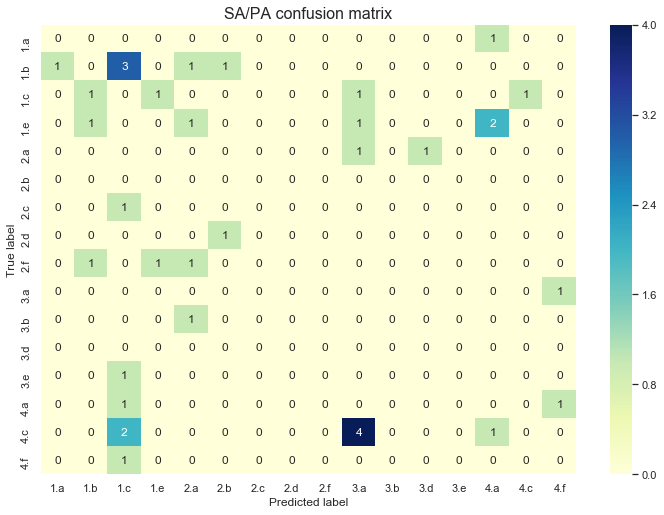

In [44]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

confusion_matrix_true = []
confusion_matrix_pred = []
for sentence in to_evaluate_df_dict:
    if sentence in manually_labelled_df_dict:
        intersected = set(to_evaluate_df_dict[sentence]).intersection(set(manually_labelled_df_dict[sentence]))
        for label in (set(manually_labelled_df_dict[sentence]) - intersected):
            for label_pred in (set(to_evaluate_df_dict[sentence]) - intersected):
                confusion_matrix_true.append(label)
                confusion_matrix_pred.append(label_pred)
confused_labels = list(sorted(set(confusion_matrix_true).union(set(confusion_matrix_pred))))
df = pd.DataFrame(confusion_matrix(confusion_matrix_true, confusion_matrix_pred), index=confused_labels, columns=confused_labels)

sns.set(rc={'figure.figsize':(12,8.27)})
ax = sns.heatmap(df, annot=True, fmt="d", cmap="YlGnBu")
ax.set(xlabel='Predicted label', ylabel='True label')
plt.title("SA/PA confusion matrix",size=16)

In [39]:
dict_with_all = {}
for sentence in manually_labelled_df_dict:
    for label in manually_labelled_df_dict[sentence]:
        if label not in dict_with_all:
            dict_with_all[label] = 0
        dict_with_all[label] += 1

Text(0.5, 1.0, 'SA/PA with most missed results')

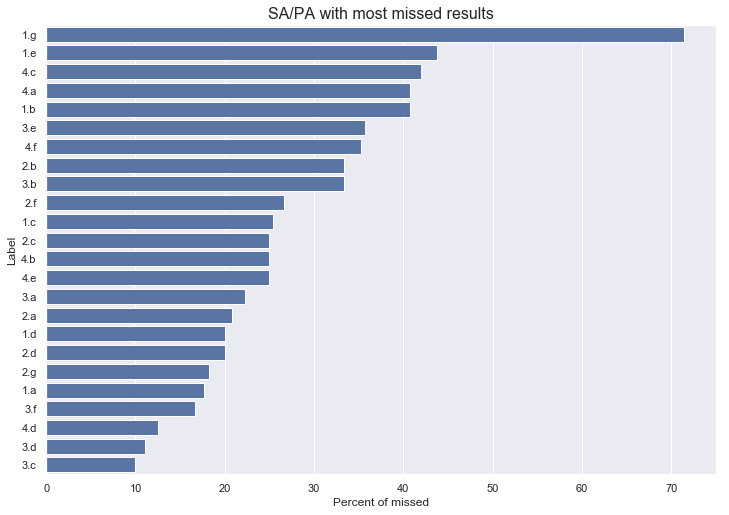

In [41]:
dict_with_missed = {}
for sentence in to_evaluate_df_dict:
    if sentence in manually_labelled_df_dict:
        for label in set(manually_labelled_df_dict[sentence]) - set(to_evaluate_df_dict[sentence]):
            if label not in dict_with_missed:
                dict_with_missed[label] = 0
            dict_with_missed[label] += 1
for label in dict_with_missed:
    dict_with_missed[label] = (dict_with_missed[label] * 100 / dict_with_all[label])
df_with_missed = pd.DataFrame(
    sorted(dict_with_missed.items(), key=lambda x: x[1], reverse=True), columns=["Label", "Percent of missed"])
sns.barplot(x="Percent of missed", y="Label", data=df_with_missed,
            label="SA/PA with most missed results", color="b")
plt.title("SA/PA with most missed results",size=16)

Text(0.5, 1.0, 'SA/PA with most found results')

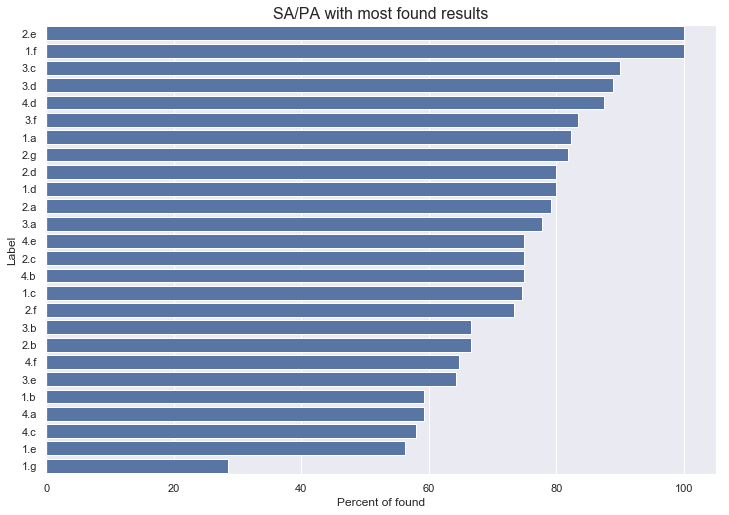

In [43]:
dict_with_found = {}
for sentence in to_evaluate_df_dict:
    if sentence in manually_labelled_df_dict:
        for label in set(manually_labelled_df_dict[sentence]).intersection(set(to_evaluate_df_dict[sentence])):
            if label not in dict_with_found:
                dict_with_found[label] = 0
            dict_with_found[label] += 1
for label in dict_with_found:
    dict_with_found[label] = (dict_with_found[label] * 100 / dict_with_all[label])
df_with_found = pd.DataFrame(
    sorted(dict_with_found.items(), key=lambda x: x[1], reverse=True), columns=["Label", "Percent of found"])
sns.barplot(x="Percent of found", y="Label", data=df_with_found,
            label="SA/PA with most found results", color="b")
plt.title("SA/PA with most found results",size=16)

# Outcomes experiments

## Create a pool of sentences to label outcomes
If you have a file with sentences you don't need to run it

In [242]:
new_df_values = []
for i in range(len(articles_df)):
    for sent in [s for s in sent_tokenize(articles_df["abstract"].values[i]) if "?" not in s]:
        new_df_values.append(sent)
new_df = pd.DataFrame(new_df_values, columns=["abstract"])
new_df["title"] = ""
new_df["keywords"] = ""
new_df["identificators"] = ""

In [68]:
new_df = excel_reader.ExcelReader().read_df_from_excel("all_sentences.xlsx")

Read file all_sentences.xlsx: 122.30s
Processed file all_sentences.xlsx: 159.86s


In [69]:
from text_processing import search_engine_insensitive_to_spelling
use_saved = True
small_search_engine_inverted_index = search_engine_insensitive_to_spelling.SearchEngineInsensitiveToSpelling(load_abbreviations = True)
if use_saved:
    small_search_engine_inverted_index.load_model("../model/search_index_outcomes_df")
else:
    small_search_engine_inverted_index.create_inverted_index(new_df)
    small_search_engine_inverted_index.save_model("../model/search_index_outcomes_df")

In [244]:
from interventions_labeling_lib import interventions_search_for_labeling
interventions_search_for_labeling = reload(interventions_search_for_labeling)
from text_processing import all_column_filler
all_column_filler = reload(all_column_filler)

_all_column_filler = all_column_filler.AllColumnFiller()
new_df = _all_column_filler.fill_columns_for_df(new_df, small_search_engine_inverted_index, _abbreviations_resolver,settings_json = {"columns":[
   {"column_filler_class":"ColumnFiller", "column_name": "outcomes_found", "column_details": "outcomes_details", "column_dictionary":"../data/outcomes_dictionary.xlsx"}]})

Started processing  {'column_filler_class': 'ColumnFiller', 'column_name': 'outcomes_found', 'column_details': 'outcomes_details', 'column_dictionary': '../data/outcomes_dictionary.xlsx'}
High level label: Soil health
High level label: Water use
High level label: Fertilizer use
High level label: Gender
High level label: Market access
High level label: Nutrition
High level label: Resilience
High level label: Production
High level label: Livelihood
High level label: Greenhouse gas emissions
Labelled articles with outcomes: 295216
Processed for 39.051207542419434s


In [442]:
new_df["Keyword_increase"] = ""
for i in small_search_engine_inverted_index.find_articles_with_keywords(["increase", "increasing", "strengthen", "boost", "improve", "improving",
             "strengthening", "reduce", "reducing", "decrease", "decreasing", "enhance", "enhancing", "raise", "raising",
             "higher", "lower", "increase", "decrease", "enhance", "improve", "promote", "boost", "expand", 
                     "increased", "increasing", "decreased", "decreasing", "enhancing", "enhanced",
                    "improved", "improving", "promoted", "promoting", "boosted", "boosting", "expanding",
                    "expanded"]):
    new_df["Keyword_increase"].values[i] = "Found"

In [443]:
len(new_df[new_df["Keyword_increase"] != ""])

137131

In [79]:
excel_writer.ExcelWriter().save_df_in_excel(new_df, "all_sentences.xlsx")

Saving...
Saved to all_sentences.xlsx


## Generate a file with outcomes to label manually

In [9]:
new_df = excel_reader.ExcelReader().read_df_from_excel("all_sentences.xlsx")

In [47]:
outcomes_map = {}
outcomes_df = excel_reader.ExcelReader().read_df_from_excel("../data/outcomes_dictionary.xlsx")
for i in range(len(outcomes_df)):
    if outcomes_df["High level label"].values[i] not in outcomes_map:
        outcomes_map[outcomes_df["High level label"].values[i]] = []
    outcomes_map[outcomes_df["High level label"].values[i]].append(outcomes_df["Keyword"].values[i])

Read file ../data/outcomes_dictionary.xlsx: 0.18s
Processed file ../data/outcomes_dictionary.xlsx: 0.01s


In [78]:
len(new_df[new_df["Taken"] == 1])

2364

In [258]:
found_words = {}
for i in range(len(new_df)):
    if new_df["Taken"].values[i] == 1:
        continue
    if new_df["Keyword_increase"].values[i].strip() == "":
        continue
    for outcome_detail in new_df["outcomes_details"].values[i]:
        outcome_detail = re.sub("\s+", " ", re.sub("\(.*?\)", "", outcome_detail)).strip()
        if outcome_detail in outcomes_map["Greenhouse gas emissions"]:
            if outcome_detail not in found_words:
                found_words[outcome_detail] = []
            found_words[outcome_detail].append(i)

In [259]:
print(len(found_words))
for key in found_words:
    print(key, len(found_words[key]))

12
environmental impact 336
greenhouse gas emission 1038
greenhouse gas 760
gas emission 258
carbon emission 107
carbon footprint 125
methane emission 48
emission greenhouse gas 49
nitrous oxide emission 48
global warming potential 19
CO2 emission 55
net GHG emission 3


In [260]:
ind_to_take = []
for word in found_words:
    ind_to_take.extend(list(np.random.choice(found_words[word], 1)))

In [77]:
for i in ind_to_take:
    new_df["Taken"].values[i] = 1

In [71]:
indices_to_choose = {"increase": [], "wo increase": []}
for i in small_search_engine_inverted_index.find_articles_with_keywords(["price"]):
    if new_df["Taken"].values[i] == 0:
        if new_df["Keyword_increase"].values[i].strip() == "":
            indices_to_choose["wo increase"].append(i)
        else:
            indices_to_choose["increase"].append(i)

In [74]:
ind_to_take = set()
for w in ["price", "demand", "market", "importation", "import", "export", "consumer"]:
    indices_to_choose = {"increase": [], "wo increase": []}
    for i in small_search_engine_inverted_index.find_articles_with_keywords([w]):
        if new_df["Taken"].values[i] == 0:
            if new_df["Keyword_increase"].values[i].strip() == "":
                indices_to_choose["wo increase"].append(i)
            else:
                indices_to_choose["increase"].append(i)
    print(w)
    for key in indices_to_choose:
        print(key, len(indices_to_choose[key]))
        if len(indices_to_choose[key]):
            ind_to_take.update(list(np.random.choice(indices_to_choose[key], 5)))
len(ind_to_take)

price
increase 3707
wo increase 8416
demand
increase 3384
wo increase 5883
market
increase 7279
wo increase 23804
importation
increase 45
wo increase 136
import
increase 471
wo increase 1151
export
increase 1032
wo increase 3448
consumer
increase 1279
wo increase 4742


70

In [72]:
for key in indices_to_choose:
    print(key, len(indices_to_choose[key]))

increase 3707
wo increase 8416


In [104]:
a = list(np.random.choice(indices_to_choose["increase"], 25))
b = list(np.random.choice(indices_to_choose["wo increase"], 10))

In [105]:
ind_to_take = []

In [106]:
ind_to_take = ind_to_take + a + b

In [75]:
ind_to_take = list(set(ind_to_take))
len(ind_to_take)

70

In [76]:
outcome_classes = ["Soil health", "Fertilizer use", "Water use", "Gender", "Greenhouse gas emissions",
                  "Livelihood", "Market access", "Nutrition", "Production", "Resilience", 'Knowledge sharing', 
                   'Practice change', 'Social inclusion', 'Poverty reduction', 'Environment impact']
excel_writer.ExcelWriter().save_df_in_excel(
    pd.concat([new_df[["abstract"]].take(ind_to_take).rename({"abstract": "Sentence"}, axis=1).reset_index()[["Sentence"]],
               pd.DataFrame([[""]*len(outcome_classes)]*len(ind_to_take), columns=outcome_classes)], axis=1), f"train_outcome_{int(time())}.xlsx")

Saving...
Saved to train_outcome_market_access_4.xlsx


## Train outcomes model

In [7]:
import pickle
from sklearn.utils import shuffle
TRAIN_DATA, outcomes_train_label_data, outcomes_sentences_train_data, EVAL_DATA, outcomes_eval_label_data, outcomes_sentences_eval_data = pickle.load(
    open("../tmp/outcomes-2610_train_data", "rb"))
TRAIN_DATA = shuffle(TRAIN_DATA)
outcomes_train_label_data = shuffle(outcomes_train_label_data)
outcomes_sentences_train_data = shuffle(outcomes_sentences_train_data)

In [9]:
pd.DataFrame(outcomes_train_label_data, columns=["Text", "Label"])["Label"].value_counts()

Livelihood                  463
Production                  405
Greenhouse gas emissions    232
Market access               222
Nutrition                   208
Resilience                  198
Soil health                 179
Practice change             157
Gender                      147
Fertilizer use              128
Water use                   128
Knowledge sharing           125
Environment impact          117
Social inclusion            106
Poverty reduction           103
Name: Label, dtype: int64

In [10]:
pd.DataFrame(outcomes_eval_label_data, columns=["Text", "Label"])["Label"].value_counts()

Livelihood                  45
Production                  44
Nutrition                   26
Greenhouse gas emissions    24
Resilience                  22
Market access               21
Soil health                 21
Practice change             18
Gender                      16
Knowledge sharing           14
Fertilizer use              14
Environment impact          13
Social inclusion            13
Water use                   13
Poverty reduction           12
Name: Label, dtype: int64

In [21]:
labels = ['Livelihood', 'Soil health', 'Fertilizer use', 'Water use', 'Gender',
           'Greenhouse gas emissions', 'Market access', 'Nutrition',
           'Production', 'Resilience', 'Knowledge sharing', 'Practice change',
           'Social inclusion', 'Poverty reduction', 'Environment impact']
labels2id = {label: idx for idx, label in enumerate(labels)}
id2label = {idx: label for idx, label in enumerate(labels)}
def prepare_multilabel_data(outcomes_train_label_data):
    gathred_data = []
    dict_label = {}
    for i in range(len(outcomes_train_label_data)):
        if outcomes_train_label_data[i][0] not in dict_label:
            dict_label[outcomes_train_label_data[i][0]] = set()
        dict_label[outcomes_train_label_data[i][0]].add(outcomes_train_label_data[i][1])
    for key, value in dict_label.items():
        gathred_data.append((key, [(1 if label in value else 0) for label in labels]))
    return pd.DataFrame(gathred_data, columns=["text", "label"])

train_df = prepare_multilabel_data(outcomes_train_label_data)
test_df = prepare_multilabel_data(outcomes_eval_label_data)
test_res = []
for i in range(len(test_df)):
    id_labels = set()
    for _idx in range(len(test_df["label"].values[i])):
        if test_df["label"].values[i][_idx] == 1:
            id_labels.add(_idx + 1)
    if not id_labels:
        id_labels.add(len(labels) + 1)
    test_res.append(id_labels)

In [13]:
from outcomes_modelling import outcomes_sentence_labeler
outcomes_sentence_labeler = reload(outcomes_sentence_labeler)
_outcomes_sentence_labeler = outcomes_sentence_labeler.OutcomesSentenceLabeler(
    "../model/bert_exp_outcome_sentences_new_multilabel_15epoch_1300_mixed_0.7",
    gpu_device_num=0, multilabel=True, label_list=list(range(len(labels))),
    epoch_num=15)

C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.d

Started tokenizer loading
Used gpu 0
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model partly loaded
Tokenizrer loaded
0
INFO:tensorflow:Using config: {'_model_dir': '../model/bert_exp_outcome_sentences_new_multilabel_15epoch_1300_mixed_0.7', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 500, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000014613EAA898>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '../model/bert_exp_outcome_sentences_new_multilabel_15epoch_1300_mixed_0.7', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 500, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000014613EAA898>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


Config is done


In [15]:
res = _outcomes_sentence_labeler.train_model(train_df, test_df)

In [30]:
res_prob, res_label, _ = _outcomes_sentence_labeler.predict_for_df(test_df)

print("F1 measure(multilabel): ", utils.get_f1_multi_label(res_prob, test_res, max_label=len(labels)+1))
print("Accuracy(multilabel): ", utils.get_accuracy_multi_label(res_prob, test_res, max_label=len(labels)+1))
print("Per label statistics")
print_per_label_stats(test_res, res_label)

273 273
F1 measure(multilabel):  0.6471306471306469
Accuracy(multilabel):  0.6776556776556777
Per label statistics
Livelihood
[[225   3]
 [ 16  29]]
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       228
           1       0.91      0.64      0.75        45

   micro avg       0.93      0.93      0.93       273
   macro avg       0.92      0.82      0.86       273
weighted avg       0.93      0.93      0.93       273

F1 score:  0.856367513083931
Soil health
[[251   1]
 [  9  12]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       252
           1       0.92      0.57      0.71        21

   micro avg       0.96      0.96      0.96       273
   macro avg       0.94      0.78      0.84       273
weighted avg       0.96      0.96      0.96       273

F1 score:  0.8431755514705883
Fertilizer use
[[259   0]
 [  4  10]]
              precision    recall  f1-score   support

          

# Experiments with NER

In [4]:
excel_reader = reload(excel_reader)
train_df = excel_reader.ExcelReader().read_folder("../tmp/usaid_interv_data_to_train")

Read file ../tmp/usaid_interv_data_to_train\jaron_labelled_usaid.xlsx: 0.01s
Processed file ../tmp/usaid_interv_data_to_train\jaron_labelled_usaid.xlsx: 0.01s
Read file ../tmp/usaid_interv_data_to_train\mary_labelled_usaid_1.xlsx: 0.01s
Processed file ../tmp/usaid_interv_data_to_train\mary_labelled_usaid_1.xlsx: 0.01s
Read file ../tmp/usaid_interv_data_to_train\mary_labelled_usaid_12.xlsx: 0.02s
Processed file ../tmp/usaid_interv_data_to_train\mary_labelled_usaid_12.xlsx: 0.01s
Read file ../tmp/usaid_interv_data_to_train\mary_labelled_usaid_2.xlsx: 0.01s
Processed file ../tmp/usaid_interv_data_to_train\mary_labelled_usaid_2.xlsx: 0.01s
Read file ../tmp/usaid_interv_data_to_train\mary_labelled_usaid_3.xlsx: 0.01s
Processed file ../tmp/usaid_interv_data_to_train\mary_labelled_usaid_3.xlsx: 0.01s
Read file ../tmp/usaid_interv_data_to_train\matu_labelled_new.xlsx: 0.02s
Processed file ../tmp/usaid_interv_data_to_train\matu_labelled_new.xlsx: 0.01s
Read file ../tmp/usaid_interv_data_to_trai

In [114]:
all_data = []
y = []
outcomes_data_folder = "../tmp/usaid_interv_data_to_train"
for file in os.listdir(outcomes_data_folder):
    df_outcome_mary = excel_reader.ExcelReader().read_df_from_excel(os.path.join(outcomes_data_folder, file))
    for i in range(len(df_outcome_mary)):
        outcomes = []
        outcomes_per_label = []
        outcomes_labels = []
        for column in ["Sanitation/Hygiene", "Water quality/Human health", "Water infrastructure",
                       "Sustainability/Environmental health", "Community and behavior",
                       "Assessment tool or program", "Policy", "Agriculture"]:
            outcomes_found = set([outcome for outcome in df_outcome_mary[column].values[i].split(";") if outcome.strip()])
            outcomes.extend(outcomes_found)
            for outcome in outcomes_found:
                outcomes_per_label.append((outcome, column))
            
            outcomes_labels.append(1 if len(outcomes_found) else 0)
        y.append(outcomes_labels)
        outcomes_found = set()
        for sent in nltk.sent_tokenize(df_outcome_mary["Sentence"].values[i]):
            found_entities = []
            found_outcome_plus_labels = []
            for outcome, label in outcomes_per_label:
                outcome = outcome.strip().strip(",").strip(".").strip()
                if outcome.lower() in sent.lower():
                    start_ind = sent.lower().rfind(outcome.lower())
                    end_ind = start_ind + len(outcome)
                    if sent[start_ind: end_ind].lower() != outcome.lower():
                        print(sent)
                        print(start_ind, end_ind)
                        print(sent[start_ind: end_ind])
                        print(sent[start_ind: end_ind].lower(), outcome.lower())
                    found_entities.append((start_ind, end_ind, 'OUTCOME'))
                    outcomes_found.add(outcome)
                    found_outcome_plus_labels.append((outcome, label))
            all_data.append((sent, {'entities': found_entities}, found_outcome_plus_labels))
        if len(outcomes_found) != len(set(outcomes)):
            print(outcomes, outcomes_found)
            print(i)
print("All data ", len(all_data))

Read file ../tmp/usaid_interv_data_to_train\jaron_labelled_usaid.xlsx: 0.02s
Processed file ../tmp/usaid_interv_data_to_train\jaron_labelled_usaid.xlsx: 0.01s
Read file ../tmp/usaid_interv_data_to_train\mary_labelled_new.xlsx: 0.03s
Processed file ../tmp/usaid_interv_data_to_train\mary_labelled_new.xlsx: 0.01s
Read file ../tmp/usaid_interv_data_to_train\mary_labelled_usaid_1.xlsx: 0.01s
Processed file ../tmp/usaid_interv_data_to_train\mary_labelled_usaid_1.xlsx: 0.01s
Read file ../tmp/usaid_interv_data_to_train\mary_labelled_usaid_12.xlsx: 0.02s
Processed file ../tmp/usaid_interv_data_to_train\mary_labelled_usaid_12.xlsx: 0.01s
Read file ../tmp/usaid_interv_data_to_train\mary_labelled_usaid_2.xlsx: 0.04s
Processed file ../tmp/usaid_interv_data_to_train\mary_labelled_usaid_2.xlsx: 0.01s
Read file ../tmp/usaid_interv_data_to_train\mary_labelled_usaid_3.xlsx: 0.02s
Processed file ../tmp/usaid_interv_data_to_train\mary_labelled_usaid_3.xlsx: 0.01s
Read file ../tmp/usaid_interv_data_to_trai

In [80]:
all_data = []
y = []
outcomes_data_folder = "../tmp/outcomes_data"
for file in os.listdir(outcomes_data_folder):
    df_outcome_mary = excel_reader.ExcelReader().read_df_from_excel(os.path.join(outcomes_data_folder, file))
    for i in range(len(df_outcome_mary)):
        outcomes = []
        outcomes_per_label = []
        outcomes_labels = []
        for column in ['Soil health', 'Fertilizer use', 'Water use', 'Gender',
           'Greenhouse gas emissions', 'Livelihood', 'Market access', 'Nutrition',
           'Production', 'Resilience', 'Knowledge sharing', 'Practice change',
           'Social inclusion','Poverty reduction' ,'Environment impact']:
            outcomes_found = set([outcome for outcome in df_outcome_mary[column].values[i].split(";") if outcome.strip()])
            outcomes.extend(outcomes_found)
            for outcome in outcomes_found:
                outcomes_per_label.append((outcome, column))
            
            outcomes_labels.append(1 if len(outcomes_found) else 0)
        y.append(outcomes_labels)
        outcomes_found = set()
        for sent in nltk.sent_tokenize(df_outcome_mary["Sentence"].values[i]):
            found_entities = []
            found_outcome_plus_labels = []
            for outcome, label in outcomes_per_label:
                outcome = outcome.strip().strip(",").strip(".").strip()
                if outcome.lower() in sent.lower():
                    start_ind = sent.lower().rfind(outcome.lower())
                    end_ind = start_ind + len(outcome)
                    if sent[start_ind: end_ind].lower() != outcome.lower():
                        print(sent)
                        print(start_ind, end_ind)
                        print(sent[start_ind: end_ind])
                        print(sent[start_ind: end_ind].lower(), outcome.lower())
                    found_entities.append((start_ind, end_ind, 'OUTCOME'))
                    outcomes_found.add(outcome)
                    found_outcome_plus_labels.append((outcome, label))
            all_data.append((sent, {'entities': found_entities}, found_outcome_plus_labels))
        if len(outcomes_found) != len(set(outcomes)):
            print(outcomes, outcomes_found)
            print(i)
print("All data ", len(all_data))

Read file ../tmp/outcomes_data\train_dfs_outcomes.xlsx: 0.10s
Processed file ../tmp/outcomes_data\train_dfs_outcomes.xlsx: 0.10s
Read file ../tmp/outcomes_data\train_fertilizer_4.xlsx: 0.05s
Processed file ../tmp/outcomes_data\train_fertilizer_4.xlsx: 0.02s
Read file ../tmp/outcomes_data\train_gender.xlsx: 0.06s
Processed file ../tmp/outcomes_data\train_gender.xlsx: 0.02s
Read file ../tmp/outcomes_data\train_mary_fertilizer.xlsx: 0.04s
Processed file ../tmp/outcomes_data\train_mary_fertilizer.xlsx: 0.02s
Read file ../tmp/outcomes_data\train_mary_water.xlsx: 0.05s
Processed file ../tmp/outcomes_data\train_mary_water.xlsx: 0.02s
Read file ../tmp/outcomes_data\train_outcome_.xlsx: 0.04s
Processed file ../tmp/outcomes_data\train_outcome_.xlsx: 0.05s
Read file ../tmp/outcomes_data\train_outcome_GHG.xlsx: 0.03s
Processed file ../tmp/outcomes_data\train_outcome_GHG.xlsx: 0.01s
Read file ../tmp/outcomes_data\train_outcome_GHG_3.xlsx: 0.04s
Processed file ../tmp/outcomes_data\train_outcome_GHG_

In [115]:
from skmultilearn.model_selection import iterative_train_test_split
from skmultilearn.model_selection.measures import get_combination_wise_output_matrix
X_train, y_train, X_test, y_test = iterative_train_test_split(np.asarray(all_data), np.asarray(y), test_size = 0.1)

In [534]:
def split_outcomes_data(merged_data):
    train_data = []
    train_data_outcomes = []
    for data in merged_data:
        train_data.append((data[0], data[1]))
        train_data_outcomes.extend(data[2])
    return train_data, train_data_outcomes
        

TRAIN_DATA, outcomes_train_label_data = split_outcomes_data(all_data)
EVAL_DATA, outcomes_eval_label_data = split_outcomes_data(all_data)
print("Train data", len(TRAIN_DATA))
print("Test data", len(EVAL_DATA))

Train data 275
Test data 275


In [117]:
def split_outcomes_data(merged_data):
    train_data = []
    train_data_outcomes = []
    for data in merged_data:
        train_data.append((data[0], data[1]))
        train_data_outcomes.extend(data[2])
    return train_data, train_data_outcomes
        

TRAIN_DATA, outcomes_train_label_data = split_outcomes_data(X_train)
EVAL_DATA, outcomes_eval_label_data = split_outcomes_data(X_test)
print("Train data", len(TRAIN_DATA))
print("Test data", len(EVAL_DATA))

Train data 1427
Test data 159


In [725]:
!pip install scikit-multilearn==0.2.0

  Using cached scikit_multilearn-0.2.0-py3-none-any.whl (89 kB)


In [430]:
pd.DataFrame(outcomes_train_label_data, columns=["Text", "Label"])["Label"].value_counts()

Water infrastructure                   68
Policy                                 60
Sanitation/Hygiene                     60
Sustainability/Environmental health    57
Community and behavior                 53
Assessment tool or program             29
Human health                           22
Water quality                          12
Agriculture                             5
Name: Label, dtype: int64

In [85]:
pd.DataFrame(outcomes_eval_label_data, columns=["Text", "Label"])["Label"].value_counts()

Water infrastructure                   85
Water quality/Human health             76
Community and behavior                 48
Sanitation/Hygiene                     46
Sustainability/Environmental health    30
Assessment tool or program             28
Policy                                 26
Agriculture                            14
Name: Label, dtype: int64

In [553]:
import pickle
from sklearn.utils import shuffle
TRAIN_DATA, outcomes_train_label_data, outcomes_sentences_train_data, EVAL_DATA, outcomes_eval_label_data, outcomes_sentences_eval_data = pickle.load(open("../tmp/usaid_entity-recognition-model-more-2960_train_data", "rb"))
TRAIN_DATA = shuffle(TRAIN_DATA)
outcomes_train_label_data = shuffle(outcomes_train_label_data)
outcomes_sentences_train_data = shuffle(outcomes_sentences_train_data)

In [73]:
model = None
output_dir="../tmp/entity-recognition-model-more-2252"
n_iter=100

In [127]:
ner_model = spacy.load("../tmp/usaid_entity-recognition-model-more-3012-169_iter")

In [74]:
import spacy
if model is not None:
    ner_model = spacy.load(model)  # load existing spaCy model
    print("Loaded model '%s'" % model)
else:
# this will create a blank english model
    ner_model = spacy.blank('en')  # create blank Language class
    print("Created blank 'en' model")

Created blank 'en' model


In [75]:
# create the built-in pipeline components and add them to the pipeline
    # nlp.create_pipe works for built-ins that are registered with spaCy
if 'ner' not in ner_model.pipe_names:
    ner = ner_model.create_pipe('ner')
    ner_model.add_pipe(ner, last=True)
# otherwise, get it so we can add labels
else:
    ner_model = ner_model.get_pipe('ner')

In [76]:
import random
from tqdm import tqdm # loading bar
# add labels, Trains data based on annotations 
for _, annotations in TRAIN_DATA:
    for ent in annotations.get('entities'):
        ner.add_label(ent[2])

    # get names of other pipes to disable them during training
other_pipes = [pipe for pipe in ner_model.pipe_names if pipe != 'ner']
with ner_model.disable_pipes(*other_pipes):  # only train NER
    optimizer = ner_model.begin_training()
    for itn in range(n_iter):
        random.shuffle(TRAIN_DATA)
        losses = {}
        for text, annotations in tqdm(TRAIN_DATA):
            ner_model.update(
                [text],  # batch of texts
                [annotations],  # batch of annotations
                drop=0.5,  # dropout 
                sgd=optimizer,  # callable to update weights
                losses=losses)
        print(losses)

  5%|████▏                                                                                  | 1/21 [00:00<00:03,  5.68it/s]

{'ner': 252.77400120003972}


  5%|████▏                                                                                  | 1/21 [00:00<00:02,  8.59it/s]

{'ner': 149.35247996075466}


  5%|████▏                                                                                  | 1/21 [00:00<00:03,  6.08it/s]

{'ner': 113.43863248983962}


  5%|████▏                                                                                  | 1/21 [00:00<00:02,  9.77it/s]

{'ner': 125.42573908997446}


  0%|                                                                                               | 0/21 [00:00<?, ?it/s]

{'ner': 123.08307451592299}


  5%|████▏                                                                                  | 1/21 [00:00<00:03,  6.60it/s]

{'ner': 82.93344484614198}


  5%|████▏                                                                                  | 1/21 [00:00<00:02,  8.41it/s]

{'ner': 93.18786227462151}


  5%|████▏                                                                                  | 1/21 [00:00<00:02,  8.53it/s]

{'ner': 277.74337925113895}


  5%|████▏                                                                                  | 1/21 [00:00<00:03,  6.39it/s]

{'ner': 139.42081500371606}


  5%|████▏                                                                                  | 1/21 [00:00<00:03,  5.88it/s]

{'ner': 179.9816812584046}


  5%|████▏                                                                                  | 1/21 [00:00<00:02,  7.92it/s]

{'ner': 308.95151429902603}


 10%|████████▎                                                                              | 2/21 [00:00<00:01, 10.69it/s]

{'ner': 115.90853848430162}


  5%|████▏                                                                                  | 1/21 [00:00<00:03,  5.61it/s]

{'ner': 196.53070268449258}


  5%|████▏                                                                                  | 1/21 [00:00<00:02,  9.21it/s]

{'ner': 197.8040173984967}


  5%|████▏                                                                                  | 1/21 [00:00<00:02,  8.57it/s]

{'ner': 167.03322577625312}


  5%|████▏                                                                                  | 1/21 [00:00<00:02,  7.10it/s]

{'ner': 217.4057930364157}


  5%|████▏                                                                                  | 1/21 [00:00<00:03,  5.81it/s]

{'ner': 147.65809705793518}


  0%|                                                                                               | 0/21 [00:00<?, ?it/s]

{'ner': 209.04482847405356}


  0%|                                                                                               | 0/21 [00:00<?, ?it/s]

{'ner': 264.4526462699272}


  5%|████▏                                                                                  | 1/21 [00:00<00:02,  7.91it/s]

{'ner': 227.90850728066533}


  5%|████▏                                                                                  | 1/21 [00:00<00:02,  7.26it/s]

{'ner': 378.6186274921988}


  5%|████▏                                                                                  | 1/21 [00:00<00:03,  5.40it/s]

{'ner': 366.0558375349873}


  0%|                                                                                               | 0/21 [00:00<?, ?it/s]

{'ner': 147.4450091779791}


  5%|████▏                                                                                  | 1/21 [00:00<00:03,  6.14it/s]

{'ner': 176.2580693945749}


  5%|████▏                                                                                  | 1/21 [00:00<00:02,  7.34it/s]

{'ner': 168.68995277085563}


  5%|████▏                                                                                  | 1/21 [00:00<00:03,  6.28it/s]

{'ner': 178.14279138630877}


  5%|████▏                                                                                  | 1/21 [00:00<00:02,  7.65it/s]

{'ner': 133.05164458687028}


  5%|████▏                                                                                  | 1/21 [00:00<00:02,  7.11it/s]

{'ner': 143.18868830428423}


  0%|                                                                                               | 0/21 [00:00<?, ?it/s]

{'ner': 131.80530417761477}


  5%|████▏                                                                                  | 1/21 [00:00<00:03,  6.41it/s]

{'ner': 170.187085133609}


  0%|                                                                                               | 0/21 [00:00<?, ?it/s]

{'ner': 146.1196416073715}


  5%|████▏                                                                                  | 1/21 [00:00<00:02,  6.91it/s]

{'ner': 142.66416800796628}


  5%|████▏                                                                                  | 1/21 [00:00<00:03,  6.24it/s]

{'ner': 110.53133822415792}


  0%|                                                                                               | 0/21 [00:00<?, ?it/s]

{'ner': 129.0039791568771}


  5%|████▏                                                                                  | 1/21 [00:00<00:03,  6.64it/s]

{'ner': 131.3598766101335}


  5%|████▏                                                                                  | 1/21 [00:00<00:02,  6.78it/s]

{'ner': 155.00338412835305}


  5%|████▏                                                                                  | 1/21 [00:00<00:02,  6.88it/s]

{'ner': 128.083752359262}


  5%|████▏                                                                                  | 1/21 [00:00<00:03,  6.19it/s]

{'ner': 100.57533221511092}


  5%|████▏                                                                                  | 1/21 [00:00<00:03,  5.82it/s]

{'ner': 92.44489153947133}


  5%|████▏                                                                                  | 1/21 [00:00<00:02,  6.91it/s]

{'ner': 107.53501087138798}


  0%|                                                                                               | 0/21 [00:00<?, ?it/s]

{'ner': 81.53965295634947}


  5%|████▏                                                                                  | 1/21 [00:00<00:03,  5.67it/s]

{'ner': 86.7593117554884}


  0%|                                                                                               | 0/21 [00:00<?, ?it/s]

{'ner': 95.48951639916277}


  0%|                                                                                               | 0/21 [00:00<?, ?it/s]

{'ner': 81.81359288944277}


  0%|                                                                                               | 0/21 [00:00<?, ?it/s]

{'ner': 70.61072846756132}


  5%|████▏                                                                                  | 1/21 [00:00<00:02,  7.16it/s]

{'ner': 60.04854236346983}


  0%|                                                                                               | 0/21 [00:00<?, ?it/s]

{'ner': 65.82353925100479}


  5%|████▏                                                                                  | 1/21 [00:00<00:02,  7.04it/s]

{'ner': 35.34071530218244}


  5%|████▏                                                                                  | 1/21 [00:00<00:02,  6.71it/s]

{'ner': 36.06086223855525}


  5%|████▏                                                                                  | 1/21 [00:00<00:02,  6.89it/s]

{'ner': 47.941360499970884}


  5%|████▏                                                                                  | 1/21 [00:00<00:02,  7.76it/s]

{'ner': 41.37080181326292}


  0%|                                                                                               | 0/21 [00:00<?, ?it/s]

{'ner': 52.5878801612654}


  5%|████▏                                                                                  | 1/21 [00:00<00:03,  5.70it/s]

{'ner': 50.990923001773155}


  5%|████▏                                                                                  | 1/21 [00:00<00:02,  7.14it/s]

{'ner': 37.644711662349636}


  5%|████▏                                                                                  | 1/21 [00:00<00:03,  6.36it/s]

{'ner': 39.67735440047436}


  5%|████▏                                                                                  | 1/21 [00:00<00:03,  5.60it/s]

{'ner': 53.42422329332297}


  5%|████▏                                                                                  | 1/21 [00:00<00:02,  6.84it/s]

{'ner': 41.34838403403864}


  5%|████▏                                                                                  | 1/21 [00:00<00:02,  7.41it/s]

{'ner': 22.222939161397395}


  5%|████▏                                                                                  | 1/21 [00:00<00:03,  6.09it/s]

{'ner': 37.896798416855574}


  5%|████▏                                                                                  | 1/21 [00:00<00:03,  5.07it/s]

{'ner': 40.34776868336425}


  0%|                                                                                               | 0/21 [00:00<?, ?it/s]

{'ner': 18.03006471049622}


  5%|████▏                                                                                  | 1/21 [00:00<00:02,  7.34it/s]

{'ner': 18.739947440167178}


  5%|████▏                                                                                  | 1/21 [00:00<00:03,  5.09it/s]

{'ner': 51.13664805243512}


  5%|████▏                                                                                  | 1/21 [00:00<00:02,  7.63it/s]

{'ner': 26.721476994883556}


  0%|                                                                                               | 0/21 [00:00<?, ?it/s]

{'ner': 33.85643823211067}


  5%|████▏                                                                                  | 1/21 [00:00<00:03,  5.90it/s]

{'ner': 55.5200470990734}


  0%|                                                                                               | 0/21 [00:00<?, ?it/s]

{'ner': 25.60191824876416}


  5%|████▏                                                                                  | 1/21 [00:00<00:03,  6.02it/s]

{'ner': 62.32048718987265}


  0%|                                                                                               | 0/21 [00:00<?, ?it/s]

{'ner': 50.905796239271126}


  5%|████▏                                                                                  | 1/21 [00:00<00:03,  5.73it/s]

{'ner': 27.36515301568913}


  5%|████▏                                                                                  | 1/21 [00:00<00:03,  5.68it/s]

{'ner': 11.875247736376505}


  5%|████▏                                                                                  | 1/21 [00:00<00:02,  6.92it/s]

{'ner': 32.51852094462002}


  5%|████▏                                                                                  | 1/21 [00:00<00:03,  5.65it/s]

{'ner': 15.689676359802768}


  5%|████▏                                                                                  | 1/21 [00:00<00:03,  5.02it/s]

{'ner': 9.076225846259137}


  5%|████▏                                                                                  | 1/21 [00:00<00:03,  5.22it/s]

{'ner': 17.97333224853285}


  5%|████▏                                                                                  | 1/21 [00:00<00:03,  6.10it/s]

{'ner': 11.517690541945605}


  0%|                                                                                               | 0/21 [00:00<?, ?it/s]

{'ner': 31.66443750479525}


  5%|████▏                                                                                  | 1/21 [00:00<00:02,  6.75it/s]

{'ner': 16.95774921502892}


  0%|                                                                                               | 0/21 [00:00<?, ?it/s]

{'ner': 16.271082846527783}


  5%|████▏                                                                                  | 1/21 [00:00<00:02,  7.67it/s]

{'ner': 15.69312804500042}


  0%|                                                                                               | 0/21 [00:00<?, ?it/s]

{'ner': 14.541442321207118}


  0%|                                                                                               | 0/21 [00:00<?, ?it/s]

{'ner': 19.434385257752453}


  0%|                                                                                               | 0/21 [00:00<?, ?it/s]

{'ner': 4.965162397068147}


  5%|████▏                                                                                  | 1/21 [00:00<00:03,  5.74it/s]

{'ner': 22.897114280875414}


  5%|████▏                                                                                  | 1/21 [00:00<00:03,  5.42it/s]

{'ner': 18.142334636604847}


  0%|                                                                                               | 0/21 [00:00<?, ?it/s]

{'ner': 12.89568492433887}


  0%|                                                                                               | 0/21 [00:00<?, ?it/s]

{'ner': 18.944748968778267}


  0%|                                                                                               | 0/21 [00:00<?, ?it/s]

{'ner': 14.178580464282128}


  0%|                                                                                               | 0/21 [00:00<?, ?it/s]

{'ner': 10.897955915885523}


  0%|                                                                                               | 0/21 [00:00<?, ?it/s]

{'ner': 2.047072900486871}


  5%|████▏                                                                                  | 1/21 [00:00<00:03,  5.85it/s]

{'ner': 2.6397857867354633}


  5%|████▏                                                                                  | 1/21 [00:00<00:03,  6.41it/s]

{'ner': 9.394044055411205}


  5%|████▏                                                                                  | 1/21 [00:00<00:02,  7.66it/s]

{'ner': 1.4161849083895637}


  5%|████▏                                                                                  | 1/21 [00:00<00:02,  6.78it/s]

{'ner': 4.532403426883416}


  5%|████▏                                                                                  | 1/21 [00:00<00:03,  5.74it/s]

{'ner': 6.552329043970507}


  0%|                                                                                               | 0/21 [00:00<?, ?it/s]

{'ner': 36.5092015974365}


  5%|████▏                                                                                  | 1/21 [00:00<00:03,  6.59it/s]

{'ner': 10.759063849611213}


  0%|                                                                                               | 0/21 [00:00<?, ?it/s]

{'ner': 16.56836942807715}


  0%|                                                                                               | 0/21 [00:00<?, ?it/s]

{'ner': 9.660111616167711}


100%|██████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:03<00:00,  5.34it/s]

{'ner': 15.29699359339359}


In [14]:
ner_model.to_disk(output_dir)

In [431]:
import spacy
from spacy.gold import GoldParse
from spacy.scorer import Scorer
def evaluate(model, examples):
    scorer = Scorer()
    cnt = 0
    for input_, annot in examples:
        doc_gold_text = model.make_doc(input_)
        gold = GoldParse(doc_gold_text, entities=annot['entities'])
        pred_value = model(input_)
        
        if len(annot['entities']) == 0 and len([(ent.text, ent.label_) for ent in pred_value.ents]) == 0:
            scorer.ner.tp += 1
            for label in scorer.ner_per_ents:
                scorer.ner_per_ents[label].tp += 1
            cnt += 1
        else:
            try:
                scorer.score(pred_value, gold)
            except:
                print(input_)
                pass
    return scorer.scores

In [535]:
ner_model = spacy.load("../tmp/usaid_entity-recognition-model-more-2685-158_iter")
evaluate(ner_model, EVAL_DATA)

Market Development The Market Development Program (MDP) should continue to work aggressively to assist women's associations to open retail shops in nearby markets for the sale of their produce.


{'uas': 0.0,
 'las': 0.0,
 'ents_p': 39.51762523191095,
 'ents_r': 37.83303730017762,
 'ents_f': 38.656987295825765,
 'ents_per_type': {'OUTCOME': {'p': 39.51762523191095,
   'r': 37.83303730017762,
   'f': 38.656987295825765}},
 'tags_acc': 0.0,
 'token_acc': 100.0}

In [536]:
ner_model = spacy.load("../tmp/usaid_entity-recognition-model-more-2685")
evaluate(ner_model, EVAL_DATA)

Market Development The Market Development Program (MDP) should continue to work aggressively to assist women's associations to open retail shops in nearby markets for the sale of their produce.


{'uas': 0.0,
 'las': 0.0,
 'ents_p': 36.706689536878216,
 'ents_r': 38.07829181494662,
 'ents_f': 37.37991266375546,
 'ents_per_type': {'OUTCOME': {'p': 36.706689536878216,
   'r': 38.07829181494662,
   'f': 37.37991266375546}},
 'tags_acc': 0.0,
 'token_acc': 100.0}

In [537]:
ner_model = spacy.load("../tmp/usaid_entity-recognition-model-more-2685-135_iter")
evaluate(ner_model, EVAL_DATA)

Market Development The Market Development Program (MDP) should continue to work aggressively to assist women's associations to open retail shops in nearby markets for the sale of their produce.


{'uas': 0.0,
 'las': 0.0,
 'ents_p': 37.93677204658902,
 'ents_r': 40.7871198568873,
 'ents_f': 39.310344827586206,
 'ents_per_type': {'OUTCOME': {'p': 37.93677204658902,
   'r': 40.7871198568873,
   'f': 39.310344827586206}},
 'tags_acc': 0.0,
 'token_acc': 100.0}

In [538]:
test_data = []
for r in outcomes_train_label_data:
    test_data.append((r[0], r[0], r[1]))
test_data = pd.DataFrame(test_data, columns=["Narrow concept", "Broad concepts", "Label"])

test_data["Label"] = [usaid_intervention_labels.USAIDInterventionLabels.INTERVENTION_LABEL_TO_NUMBER[test_data["Label"].values[i]] for i in range(len(test_data))]
deduplicated2labels = deduplicate([test_data])

intervention_labeling = reload(intervention_labeling)
intervention_labeler = intervention_labeling.InterventionLabeling(google_models_folder="../model/synonyms_retrained_new",
                                                                 label_non_intervention=2, class_weights={}, binary=True)
common_folder = "../model/usaid_interventions_multi"
test_labels = []
for label in usaid_intervention_labels.USAIDInterventionLabels.INTERVENTION_NUMBER_TO_LABEL:
    if label != 10:
        print("#### ", usaid_intervention_labels.USAIDInterventionLabels.INTERVENTION_NUMBER_TO_LABEL[label])
        test_copy = test_data.copy()
        test_copy["Label"] = [1 if label in deduplicated2labels[normalize_full(test_copy["Narrow concept"].values[i])] else 2 for i in range(len(test_copy))]
        label_folder = os.path.join(common_folder, usaid_intervention_labels.USAIDInterventionLabels.INTERVENTION_NUMBER_TO_LABEL[label])
        intervention_labeler.load_previous_models(label_folder)
        res_label, res_prob = intervention_labeler.predict_class(test_copy.values, return_probs=True)
        test_labels.append([r[0] for r in res_prob])

print("F1 measure: ", utils.get_f1_multi_label(test_labels, [deduplicated2labels[normalize_full(test_copy["Narrow concept"].values[i])] for i in range(len(test_data))]))
print("Accuracy: ", utils.get_accuracy_multi_label(test_labels, [deduplicated2labels[normalize_full(test_copy["Narrow concept"].values[i])] for i in range(len(test_data))]))

C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\smart_open\smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Google word2vec loaded
Fast text loaded
Phrases loaded
####  Water infrastructure


../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


####  Sanitation/Hygiene


../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


####  Water quality


../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


####  Human health


../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


####  Sustainability/Environmental health


../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


####  Community and behavior


../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


####  Assessment tool or program


../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


####  Policy


../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


####  Agriculture
F1 measure:  0.7372852233676982
Accuracy:  0.8298969072164949


../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


In [162]:
evaluate(ner_model, EVAL_DATA)

We, therefore, pooled household data from two Sustainable Water Effectiveness Reviews conducted by Oxfam GB in Zambia (n ¼ 997) and the Democratic Republic of Congo (DRC, n ¼ 1,071) to assess the relationship between perceived water governance (using a 12-item indicator), water insecurity [using the Household Water Insecurity Experiences (HWISE) Scale], and four indicators of well-being: life satisfaction, drinking unsafe water, diarrhea, and resilience to cholera outbreak.


{'uas': 0.0,
 'las': 0.0,
 'ents_p': 16.666666666666664,
 'ents_r': 2.380952380952381,
 'ents_f': 4.166666666666666,
 'ents_per_type': {'OUTCOME': {'p': 16.666666666666664,
   'r': 2.380952380952381,
   'f': 4.166666666666666}},
 'tags_acc': 0.0,
 'token_acc': 100.0}

In [556]:
ner_model = spacy.load("../tmp/usaid_entity-recognition-model-more-2960")
for text, entities in EVAL_DATA:
    res = set([ent.text for ent in ner_model(text).ents])
    real = set([text[t[0]:t[1]] for t in entities["entities"]])
    if (len(res) == 0 and len(real) == 0) or (len(res.intersection(real)) == len(res.union(real))):
        continue
    print(text)
    print("Real: ", real)
    print("OK: ", res.intersection(real))
    print('Not OK result: ', res - real)
    print('Not FOUND result: ', real - res)

Referring back to the complexity of water and sanitation, there is a view that seems pervasive amongst Rotarians that development workers make issues needlessly complicated and that what is needed is simply more charity and voluntary initiatives.
Real:  {'charity and voluntary initiatives'}
OK:  set()
Not OK result:  {'simply more charity and voluntary initiatives'}
Not FOUND result:  {'charity and voluntary initiatives'}
Good water governance was also directly associated with greater odds of life satisfaction (aOR 1.24) and lower odds of both drinking unsafe water (aOR 0.91) and severe cholera impact (aOR 0.92).
Real:  {'water governance'}
OK:  set()
Not OK result:  set()
Not FOUND result:  {'water governance'}
Understanding the factors influencing decision of farmers to implement disease control programmes is therefore a key element in informing future policies aimed at improving CBPP management.
Real:  {'disease control programmes'}
OK:  {'disease control programmes'}
Not OK result:

He joined Joy Jochico of USAID/Philippines and Almud Weitz of the World Bank Water and Sanitation Program (WSP) in handing over the following documents to the League of Cities and League of Provinces of the Philippines: “Operations Manual on the Rules and Regulations Governing Domestic Sludge and Septage,” published by DOH with support from ECO-Asia; “Economic Impacts of Sanitation in the Philippines” published by the World Bank Water and Sanitation Program (WSP) with co-funding from ECO-Asia; “Universal Sanitation in East Asia,” a joint WSP-WHO-UNICEF publication; and “Sanitation Technology Information Kit” prepared by PSA.
Real:  {'Operations Manual on the Rules and Regulations Governing Domestic Sludge and Septage', 'Water and Sanitation Program (WSP)', 'Sanitation Technology Information Kit', 'Economic Impacts of Sanitation', 'Universal Sanitation'}
OK:  set()
Not OK result:  {'Water and Sanitation Program (WSP) with co-funding from ECO-Asia; “Universal Sanitation in East Asia,” a 

USDA's new incentive based programmes are reviewed (environmental quality incentives programme and Conservation Reserve programme).
Real:  {'Conservation Reserve programme', 'incentive based programmes', 'environmental quality incentives programme'}
OK:  {'incentive based programmes', 'environmental quality incentives programme'}
Not OK result:  set()
Not FOUND result:  {'Conservation Reserve programme'}
This chapter describes how the processes of community participation (including participatory extension) were field tested and became an integral part of two major agricultural development projects and one natural resource management project in the highlands of northern Thailand.
Real:  {'community participation', 'agricultural development projects', 'participatory extension', 'natural resource management project'}
OK:  {'agricultural development projects', 'natural resource management project'}
Not OK result:  set()
Not FOUND result:  {'community participation', 'participatory extensio

Not OK result:  {'absence of coordinated planning', 'sewer tariffs'}
Not FOUND result:  set()
Outside temperature had a limited effect on both the temperature and the microbiological quality of the water in the reservoirs, which did not comply with Dutch drinking water legislation and should thus not be consumed without treatment.
Real:  {'reservoirs', 'Dutch drinking water legislation'}
OK:  {'reservoirs'}
Not OK result:  {'treatment'}
Not FOUND result:  {'Dutch drinking water legislation'}
yada SELECTION, FEASBILITY STUDIES, AND P. Advise and train utilities on best practices for commercial performance, including gender equity and leadership training Collaborators (MuniWASH partners, NGOs, Caan a1 hoe | RE-INTERMEDIATE RESULT ACTIVITIES SODECI, SONEB, private service providers, SEGURA, STTA Advise utilities on cost-reducing measures from non revenue water, asset management, O&M, energy efficiency, and information systems Responsible Party (MuniWASH team lead) ES/BPAs, F&IAs, GESI Spe

follow-up support will TEST methods OF continuing communication and support OF trainees to assist them in implementing national environmental policy goals.
Real:  {'national environmental policy', 'communication and support OF trainees'}
OK:  {'national environmental policy'}
Not OK result:  {'methods OF continuing communication'}
Not FOUND result:  {'communication and support OF trainees'}
This study analyses the rural communities’ choice and perception of WSM infrastructure and their willingness to pay (WTP) for their improvement and maintenance.
Real:  {'rural communities’ choice', 'their willingness to pay (WTP)', 'perception of WSM infrastructure'}
OK:  set()
Not OK result:  {'WSM infrastructure'}
Not FOUND result:  {'rural communities’ choice', 'their willingness to pay (WTP)', 'perception of WSM infrastructure'}
The following re technologies, identified as high priority by the Government of Egypt (GOE), will be field tested at public sector sites: (1) solar applications, includi

The main part of this issue consists of 10 papers on various aspects of participatory extension in developing countries: (1) Supporting farmer extension and research ; (2) Andean community planning - encouraging Andean rationality and bridging over to western rationality - in Ecuador; (3) Participatory pre-test method in community forestry management training - in Nepal; (4) Greening the barren slopes: silvopastoral promotion in an arid Himalayan region - a case study - in Nepal; (5) Listening to farmers: indigenous technical knowledge - an important tool for community forestry development - in Nepal; (6) Putting community forestry into the curriculum; a case study from Nepal ; (7) The process continues - implementing the new community forestry curriculum at IOF - the Institute of Forestry in Nepal; (8) Participatory tools for enhancing local initiatives -an account of a 6-wk training course held in the Netherlands in 1992; (9) Of people and trees - experiences of addressing population

USAID was both daring and visionary to issue a request for applications (RFA) that integrated various technical components and funding streams, such as Water Supply and Sanitation, Agricultural Sector Capacity, Maternal and Child Health, Family Planning and Reproductive Health, Integrated Health Office, Malaria, Nutrition, etc.
Real:  {'funding streams', 'Water Supply and Sanitation'}
OK:  {'Water Supply and Sanitation'}
Not OK result:  {'Maternal and Child Health'}
Not FOUND result:  {'funding streams'}
e Technical support and training to USAID implementing partners to integrate WASH into nutrition (SPRING Project assessment showed statistically significant differences in presence of at least 2 HW stations and observed HW practices) Integrated In work plan Delivered in reports Programming: WASH-Sanitation (including | CLTSplus (plus focuses on high coverage, low inclusive sanitation), _WASH- | quality latrines) Schools (including MHM), : : WASH-Nutrition, WASH. | SDAs for upgrading le

Not OK result:  {'water sector administration, WMI and'}
Not FOUND result:  {'water sector administration'}
DGs at RWEs will refer |N/A RWEs need to hire qualified engineers to to this document as their action plan to improve water security monitor the implementation.
Real:  {'improve water security monitor'}
OK:  set()
Not OK result:  set()
Not FOUND result:  {'improve water security monitor'}
Thus while Washington can suggest opportunities and help support Missions in delivering on its objectives and strategy, ultimately it is the Missions that require the capacity and interest to make these kinds of partnerships work.
Real:  {'support Missions'}
OK:  set()
Not OK result:  set()
Not FOUND result:  {'support Missions'}
Focus group discussions and key interviews were also held along with observation.
Real:  {'Focus group discussions', 'key interviews'}
OK:  {'Focus group discussions'}
Not OK result:  {'interviews'}
Not FOUND result:  {'key interviews'}
These were reflected on the Proje

Specifically, the report: (1) describes the three major nutritional deficiencies in Haiti (protein-energy malnutrition, vitamin A deficiency, and nutritional anemia) and the magnitude of these deficiencies, and identifies populations that are especially at risk; (2) describes the major factors related to these problems which may be susceptible to education interventions; (3) assesses related constraints to behavioral change (i.e., socioeconomic and attitudinal variables); (4) describes the five models of nutritional interventions currently used to assist Haitian preschoolers (targeted supplementation with education, nutrition programs integrated into survival programs, nutritional services integrated into health services, untargeted supplementation and education programs, and education-based programs with community participation); (5) develops a framework to assess these programs; (6) identifies potentially replicable educational/growth monitoring/promotion approaches; and (7) identifi

The main objective of this paper is to shed new light on such relationships by exploring organic producers' satisfaction from extension providers and their willingness to participate in agricultural education programmes.
Real:  {'agricultural education programmes', "exploring organic producers' satisfaction from extension providers"}
OK:  {'agricultural education programmes'}
Not OK result:  set()
Not FOUND result:  {"exploring organic producers' satisfaction from extension providers"}
Economic opportunities were generated for business and small enterprise owners due to the new water supply infrastructure, and piped water infrastructure had additional positive effects for both public and private sanitation facilities
Real:  {'public and private sanitation facilities', 'piped water infrastructure', 'new water supply infrastructure'}
OK:  {'public and private sanitation facilities', 'piped water infrastructure'}
Not OK result:  {'water supply infrastructure'}
Not FOUND result:  {'new wat

As noted by participants in the debriefing meeting in Evanston, part of the challenge around finding the matching funding was due to the timing, when economic downturns were causing organizations like Rotary to tap into their reserves to support commitments to grants programs.
Real:  set()
OK:  set()
Not OK result:  {'grants programs', 'tap into their reserves'}
Not FOUND result:  set()
There are, however, few studies of packaged water production.
Real:  set()
OK:  set()
Not OK result:  {'packaged water production'}
Not FOUND result:  set()
Prime contractors must write pesticide compliance requirements as set out above into each grant or subcontract that will involve support for pesticide use Develop or adapt existing record keeping land monitoring program.
Real:  set()
OK:  set()
Not OK result:  {'land monitoring program'}
Not FOUND result:  set()
Now that many women are taking the ARV AIDS drugs, even women who had previously stopped menstruating are now returning to their menses.
Re

In [849]:
# test the trained model
for text in nltk.sent_tokenize(df["abstract"].values[10]):
    doc = ner_model(text)
    print(text)
    print('Entities', [(ent.text, ent.label_) for ent in doc.ents])

Background: The rapid global adoption of mobile health (mHealth) smartphone apps by healthcare providers presents challenges and opportunities in medicine.
Entities []
Challenges include ensuring the delivery of high-quality, up-to-date and optimised information.
Entities [('ensuring the delivery of high-quality', 'OUTCOME')]
Opportunities include the ability to study global practice patterns, access to medical and surgical care and continuing medical education needs.
Entities []
Methods: We studied users of a free anaesthesia calculator app used worldwide.
Entities []
We combined traditional app analytics with in-app surveys to collect user demographics and feedback.
Entities []
Results: 31173 subjects participated.
Entities [('31173 subjects participated', 'OUTCOME')]
Users were from 206 countries and represented a spectrum of healthcare provider roles.
Entities []
Low-income country users had greater rates of app use (p<0.001) and ascribed greater importance of the app to their prac